# Analysis of Ficus RAD-seq data

### Table of contents
[Software installation (conda)](#Required-software)  
[The assembled RAD data](#The-assembled-data-sets)  
[Phylogenetic analysis (raxml)](#Analysis-RAxML)  
[Phylogenetic analysis (iqtree)](#Analysis-IQ-tree)  
[Phylogenetic analysis (tetrad)](#Analysis-tetrad)  
[Introgression analysis (ABBA-BABA)](#Analysis-ABBA-BABA)



## Required software
All required software can be installed locally using *conda*. I assume here that you already have `ipyrad` installed using conda. 

In [1]:
## conda install toytree   -c eaton-lab
## conda install ipyrad    -c ipyrad 
## conda install bpp       -c ipyrad 
## conda install structure -c ipyrad
## conda install raxml     -c bioconda

In [2]:
## import packages
import ipyrad as ip
import ipyrad.analysis as ipa
import numpy as np
import toyplot
import toytree
import glob

## print ipyrad info
print "ipyrad v.{}".format(ip.__version__)

ipyrad v.0.6.20


## Cluster setup
see more information on ipyparallel setup here. 

In [3]:
## print ipyparallel cluster information
import ipyparallel as ipp
ipyclient = ipp.Client()
print ip.cluster_info(ipyclient)

host compute node: [40 cores] on tinus


### The assembled data sets
The data set was assembled under a range of parameter settings in [link to the assembly notebook]. We can access all of the resulting data files from the ipyrad Assembly object directly, which stores the file paths. 

In [4]:
## load all assemblies created from the assembly notebook
jsons = glob.glob("/home/deren/Documents/Ficus/analysis-ipyrad/ficus_d*.json")
dsets = [ip.load_json(path, quiet=True) for path in jsons]

## convert to a dictionaries accessible by names
dsets = {i.name: i for i in dsets}

In [5]:
dsets

{'ficus_d': <ipyrad.core.assembly.Assembly at 0x7f055cbbbed0>,
 'ficus_dhi': <ipyrad.core.assembly.Assembly at 0x7f057229f150>,
 'ficus_dhi_f10': <ipyrad.core.assembly.Assembly at 0x7f055dedbf90>,
 'ficus_dhi_f20': <ipyrad.core.assembly.Assembly at 0x7f055d8f4290>,
 'ficus_dhi_f4': <ipyrad.core.assembly.Assembly at 0x7f055db7d090>,
 'ficus_dhi_s10': <ipyrad.core.assembly.Assembly at 0x7f055dc22150>,
 'ficus_dhi_s20': <ipyrad.core.assembly.Assembly at 0x7f055e1cb390>,
 'ficus_dhi_s4': <ipyrad.core.assembly.Assembly at 0x7f055ddc23d0>,
 'ficus_dlo': <ipyrad.core.assembly.Assembly at 0x7f055d58ffd0>,
 'ficus_dlo_f10': <ipyrad.core.assembly.Assembly at 0x7f055d58fe90>,
 'ficus_dlo_f20': <ipyrad.core.assembly.Assembly at 0x7f05943bb050>,
 'ficus_dlo_f4': <ipyrad.core.assembly.Assembly at 0x7f055dca4250>,
 'ficus_dlo_s10': <ipyrad.core.assembly.Assembly at 0x7f055ca10790>,
 'ficus_dlo_s20': <ipyrad.core.assembly.Assembly at 0x7f0594301390>,
 'ficus_dlo_s4': <ipyrad.core.assembly.Assembly at 

### A function to select samples from clades
For a given data set this function returns the samples in it that are from the selected clade. 

In [50]:
## get outgroup names
def get_sample_names(data, clade):
    
    ## known clades
    c1 = ["tonduzii", "maxima", "yoponens", "glabrata", "insipida"]
    c2 = ["nymph", "obtus", "popo", "bull", "citri", "paraen"]
    c3 = ["pertus", "perfor", "dugan", "turbin", "colub", "costa", "tria", "trig"]
    
    ## select clades from a dict
    clades={
        "pharma": c1,
        "urost1": c2,
        "urost2": c3,
        "urost": c2+c3,
    }
    
    ## return selected clade names
    names = [i for i in data.samples if any([namebit in i for namebit in clades[clade]])]
    return names

# Analysis `STRUCTURE`
(Bayesian clustering analysis)

#### Create new assemblies (data files) for subclades
Here we will load an assembly and the use the subsamples argument to `.branch()` to select a subset of samples to include in the new branch. Then we recreate the final output files for the assembly with those subsamples by running step7 of the ipyrad assembly. 

In [30]:
## parent clade to make branches from
parent = dsets["ficus_dhi_s20"]

In [31]:
## create subsampled pharma-clade branch
subs = get_sample_names(parent, 'pharma')
clade1 = parent.branch("pharma-clade-min20", subsamples=subs)

## create subsampled urostigma clade branch
subs = get_sample_names(parent, 'urost')
clade2 = parent.branch("urost-clade-min20", subsamples=subs)

## assemble data sets
clade1.run("7", force=True)
clade2.run("7", force=True)


  Assembly: pharma-clade-min20
  [####################] 100%  filtering loci        | 0:00:23 | s7 | 
  [####################] 100%  building loci/stats   | 0:00:34 | s7 | 
  [####################] 100%  building alleles      | 0:00:37 | s7 | 
  [####################] 100%  building vcf file     | 0:00:45 | s7 | 
  [####################] 100%  writing vcf file      | 0:00:00 | s7 | 
  [####################] 100%  building arrays       | 0:00:13 | s7 | 
  [####################] 100%  writing outfiles      | 0:00:03 | s7 | 
  Outfiles written to: ~/Documents/Ficus/analysis-ipyrad/pharma-clade-min20_outfiles

  Assembly: urost-clade-min20
  [####################] 100%  filtering loci        | 0:00:32 | s7 | 
  [####################] 100%  building loci/stats   | 0:00:35 | s7 | 
  [####################] 100%  building alleles      | 0:00:41 | s7 | 
  [####################] 100%  building vcf file     | 0:00:53 | s7 | 
  [####################] 100%  writing vcf file      | 0:00:00 | s7 | 


#### Init structure objects for each subsampled data set
By providing a mapfile each rep that we run will randomly sample a single unlinked SNP from each RAD locus. So each rep has a slightly different data set. 

In [8]:
data = ip.load_json("./analysis-ipyrad/pharma-clade-min20.json", 1)
pstruct = ipa.structure(
    name=data.name, 
    workdir="./analysis-structure",
    strfile=data.outfiles.str, 
    mapfile=data.outfiles.snpsmap,    
)

data = data = ip.load_json("./analysis-ipyrad/urost-clade-min20.json", 1)
ustruct = ipa.structure(
    name=data.name, 
    workdir="./analysis-structure/",
    strfile=data.outfiles.str, 
    mapfile=data.outfiles.snpsmap,    
)

In [63]:
## set params for structure jobs
pstruct.mainparams.burnin = 10000   ## up to 20K
pstruct.mainparams.numreps = 50000  ## up to 100K
ustruct.mainparams.burnin = 10000
ustruct.mainparams.numreps = 50000

In [10]:
## submit 'pharma' jobs for several values of K
for kpop in [2, 3, 4, 5]:
    pstruct.submit_structure_jobs(
        kpop=kpop, 
        nreps=5, 
        seed=12345, 
        ipyclient=ipyclient)

submitted 5 structure jobs [pharma-clade-min20-K-2]
submitted 5 structure jobs [pharma-clade-min20-K-3]
submitted 5 structure jobs [pharma-clade-min20-K-4]
submitted 5 structure jobs [pharma-clade-min20-K-5]


In [12]:
for kpop in [2, 4, 6, 8, 10, 12]:
    ustruct.submit_structure_jobs(
        kpop=kpop,
        nreps=5, 
        seed=54321,
        ipyclient=ipyclient)

submitted 5 structure jobs [urost-clade-min20-K-2]
submitted 5 structure jobs [urost-clade-min20-K-4]
submitted 5 structure jobs [urost-clade-min20-K-6]
submitted 5 structure jobs [urost-clade-min20-K-8]
submitted 5 structure jobs [urost-clade-min20-K-10]
submitted 5 structure jobs [urost-clade-min20-K-12]


In [14]:
## wait for jobs to finish
ipyclient.wait()

#### collect results and summarize w/ clumpp

In [65]:
pstruct.clumppparams
pstruct.clumppparams.m = 2
pstruct.clumppparams.greedy_option = 1

In [60]:
ptables = {}
for kpop in [2, 3, 4, 5]:#, 4, 5]:
    ptables[kpop] = pstruct.get_clumpp_table(kpop)

mean scores across 5 replicates.
mean scores across 5 replicates.
mean scores across 5 replicates.
mean scores across 5 replicates.


In [ ]:
utables = {}
for kpop in [2, 4, 6, 8, 10, 12]:
    utables[kpop] = ustruct.get_clumpp_table(kpop)   

#### Plot the results

In [40]:
## ordered alphabetically for now, replace with this tree-order later
myorder = sorted(table.index.tolist(), key=lambda x: x.split("_")[1])

In [61]:
for kpop in [2, 3, 4, 5]:
    ## parse outfile to a table and re-order it
    table = ptables[kpop]
    table = table.ix[myorder]
    
    ## further styling of plot with css 
    style = {"stroke":toyplot.color.near_black, 
             "stroke-width": 1.5}
    
    ## plot barplot w/ hover
    canvas = toyplot.Canvas(width=600, height=250)
    axes = canvas.cartesian(bounds=("5%", "90%", "10%", "45%"))
    axes.bars(table, style=style)#title=hover(table), style=style)

    ticklabels = [i for i in table.index.tolist()]
    axes.x.ticks.locator = toyplot.locator.Explicit(labels=ticklabels)
    axes.x.ticks.labels.angle = -60
    axes.x.ticks.show = True
    axes.x.ticks.labels.offset = 10
    axes.x.ticks.labels.style = {"font-size": "12px"}
    axes.x.spine.style = style
    axes.y.show = False

A96_glabrata A97_glabrata B133_glabrata B134_glabrata B130_glabrataXmaxima B131_glabrataXmaxima A95_insipida B126_insipida B127_insipida B128_insipida C15_insipida C50_insipida A94_maxima B118_maxima B119_maxima B120_maxima B123_maxima C17_maxima C18_maxima C48_tonduzii C45_yoponensis C46_yoponensis C47_yoponensis 
 
 
 Save as .csv

A96_glabrata A97_glabrata B133_glabrata B134_glabrata B130_glabrataXmaxima B131_glabrataXmaxima A95_insipida B126_insipida B127_insipida B128_insipida C15_insipida C50_insipida A94_maxima B118_maxima B119_maxima B120_maxima B123_maxima C17_maxima C18_maxima C48_tonduzii C45_yoponensis C46_yoponensis C47_yoponensis 
 
 
 Save as .csv

A96_glabrata A97_glabrata B133_glabrata B134_glabrata B130_glabrataXmaxima B131_glabrataXmaxima A95_insipida B126_insipida B127_insipida B128_insipida C15_insipida C50_insipida A94_maxima B118_maxima B119_maxima B120_maxima B123_maxima C17_maxima C18_maxima C48_tonduzii C45_yoponensis C46_yoponensis C47_yoponensis 
 
 
 Save as .csv

A96_glabrata A97_glabrata B133_glabrata B134_glabrata B130_glabrataXmaxima B131_glabrataXmaxima A95_insipida B126_insipida B127_insipida B128_insipida C15_insipida C50_insipida A94_maxima B118_maxima B119_maxima B120_maxima B123_maxima C17_maxima C18_maxima C48_tonduzii C45_yoponensis C46_yoponensis C47_yoponensis 
 
 
 Save as .csv

# Analysis `RAxML`
(Maximum Likelihood & rapid bootstrapping)

In [52]:
## data sets for which we want to infer an ML tree
keys = [
    "ficus_dhi_s20", 
    "ficus_dhi_s10",
    "ficus_dhi_s4",
    "ficus_dlo_f20", 
    "ficus_dlo_f10", 
    "ficus_dlo_f4",
]

## a dictionary of raxml objects
raxdict = {}

## iterate over keys
for key in keys:
    ## select a data set
    data = dsets[key]
    
    ## init a raxml object
    raxdict[key] = ipa.raxml(
        name=data.name, 
        data=data.outfiles.phy, 
        o=get_sample_names(data, "pharma"),
        N=100, 
        T=20)
    
## print the last rax command for prosperities sake
raxdict[key].command

' -f a -T 40 -m GTRGAMMA -N 100 -x 12345 -p 54321 -n ficus_dlo_f4 -w /home/deren/Documents/Ficus/analysis-raxml -s /home/deren/Documents/Ficus/analysis-ipyrad/ficus_dlo_f4_outfiles/ficus_dlo_f4.phy -o C17_maxima,B119_maxima,B130_glabrataXmaxima,C15_insipida,B134_glabrata,B133_glabrata,A97_glabrata,C46_yoponensis,C18_maxima,B123_maxima,B128_insipida,B126_insipida,B127_insipida,A94_maxima,A96_glabrata,C48_tonduzii,A95_insipida,C50_insipida,C47_yoponensis,B120_maxima,C45_yoponensis,B131_glabrataXmaxima,B118_maxima'

#### Run the raxml analysis for each object

In [ ]:
## call raxml on each data set (command above)
for rax in raxdict:
    raxdict[rax].run()

#### Plot the results

In [ ]:
## plot the tree
tre = toytree.tree(rax.trees.bipartitions)
tre.draw(
    width=500, 
    height=1000,
    node_labels=tre.get_node_values("support"),
)

# Analysis BPP

# Analysis `IQ-TREE`
(Polymorphism-aware model)

Convert .loci file to the "counts" file format used by iqtree

In [10]:
## ip.file_conversion.loci2counts()
import os

DIR = "/home/deren/Documents/ipyrad/tests/analysis-ipyrad/"
LOCIFILE = os.path.join(DIR, "ped_min10_outfiles/ped_min10.loci")

In [7]:
POPDICT = {
    "prz": ["32082_przewalskii", "33588_przewalskii"],
    "cys": ["41478_cyathophylloides", "41954_cyathophylloides"], 
    "cya": ["30686_cyathophylla"],
    "sup": ["29154_superba"],
    "tha": ["33413_thamno", "30556_thamno"], 
    "rex": ["35236_rex", 
            "40578_rex", "35855_rex",
            "39618_rex", "38362_rex"],
    }


In [9]:
## generate the 'counts' file
loci2cf("ped.cf", LOCIFILE, POPDICT)

'./ped.cf'

In [ ]:
%%bash

## ensure output dir
mkdir -p analysis-iqtree

## run pomo inference w/ 100 bootstraps
iqtree-pomo -s ped.cf \
            -m HKY+rP+N5+W+F \
            -o prz \
            -b 100 \
            -prefix analysis-iqtree/ped.cf \
            -redo \



### real thing

In [12]:
locifile = "./analysis_ipyrad/ficus_c85d6f2_min20_outfiles/ficus_c85d6f2_min20.loci"
loci2cf("ficus.cf", locifile, clades)

'./ficus.cf'

In [16]:

print "iqtree -s ficus.cf -m HKY+rP+N5+W+F -b 100 -o", rootstr


iqtree -s ficus.cf -m HKY+rp+N5+W+F -b 100 -o C48_tonduzii,C18_maxima,A94_maxima,C17_maxima,B119_maxima,B120_maxima,B123_maxima,C45_yoponensis,C46_yoponensis,C47_yoponensis,B130_glabrataXmaxima,A96_glabrata,A97_glabrata,B133_glabrata,B131_glabrataXmaxima,B134_glabrata,A95_insipida,B127_insipida,B128_insipida,C50_insipida,B126_insipida,C15_insipida


### Analysis `tetrad`
(Inference by phylogenetic invariants within quartets)

In [10]:
import ipyrad as ip

In [11]:
data = ip.load_json("analysis-ipyrad/lodepth_min4.json")
#data.stats

  loading Assembly: lodepth_min4
  from saved path: ~/Documents/Ficus/analysis-ipyrad/lodepth_min4.json


In [ ]:
import ipyrad.analysis as ipa

tet = ipa.tetrad("ficus_85d6f2_min4_s3K", 
                 seqfile=data.outfiles.snpsphy, 
                 mapfile=data.outfiles.snpsmap,
                 workdir="analysis-tetrad", 
                 nboots=100,
                 );
tet.run()

loading seq array [95 taxa x 617503 bp]
max unlinked SNPs per quartet (nloci): 81509
host compute node: [40 cores] on tinus
inferring 3183545 induced quartet trees
[####################] 100%  initial tree | 2:57:03 |  
[#                   ]   5%  boot 5       | 13:41:05 |  
Keyboard Interrupt by user. Cleaning up...


In [26]:
import numpy as np
import toytree
import toyplot
import toyplot.pdf

  loading Assembly: lodepth_min4
  from saved path: ~/Documents/Ficus/analysis-ipyrad/lodepth_min4.json


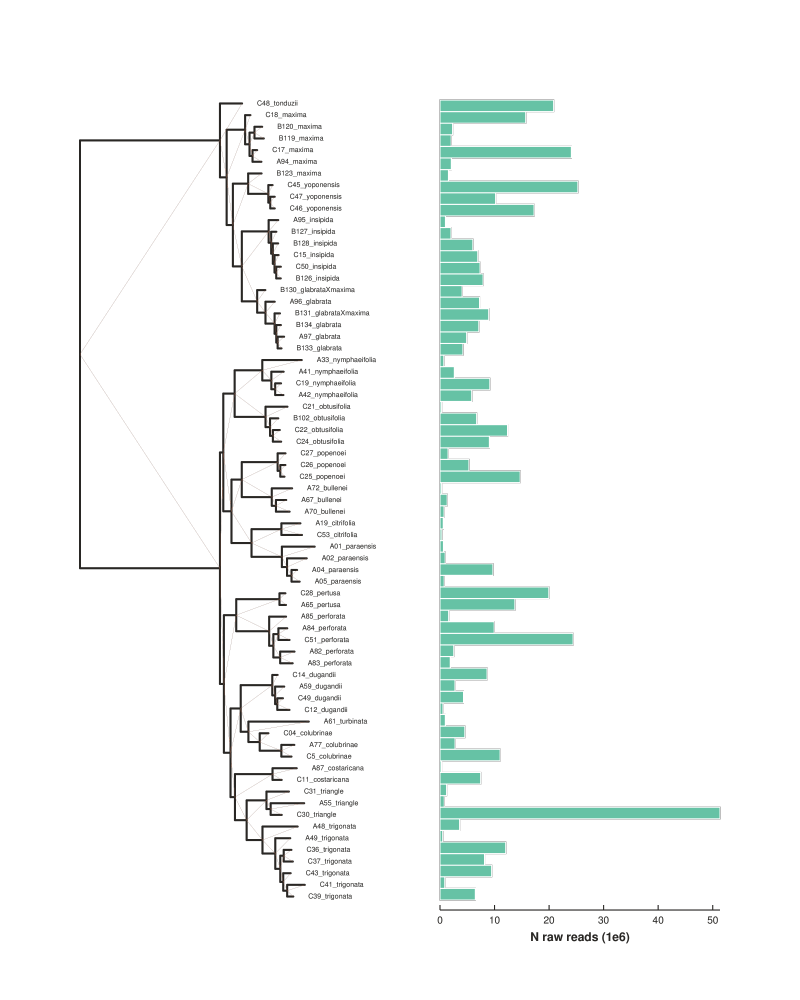

In [126]:
## load tree data
#tre = toytree.tree("analysis-tetrad/ficus_85d6f2_min4_s3K.tree")
newick="analysis_raxml/RAxML_bipartitions.ficus_c85d6f2_min4_s3K"
tre = toytree.tree(newick, format=0)

## load ipyrad data 
data = ip.load_json("analysis-ipyrad/lodepth_min4.json")
heights = data.stats.reads_raw.ix[tre.get_tip_labels()]
hdata = heights/float(1e6) 
hover = ["{}: {}".format(hdata.index[i], hdata[i]) for \
         i in range(hdata.shape[0])[::-1]]

## plot tree
canvas = toyplot.Canvas(    
    width=800, 
    height=1000,
    )
ax1 = canvas.cartesian(bounds=("10%", "50%", "10%", "90%"))
ax2 = canvas.cartesian(bounds=("55%", "90%", "10%", "90%"))

tre.draw(
    axes=ax1,
    #node_labels=True,
    node_size=5,
    use_edge_lengths=True,
    tip_labels_style={"font-size": "7px"}
    );

## add barplot
ax2.bars(hdata[::-1], 
         along='y', 
         title=hover,
         )

## style axes
ax1.show = False
ax2.y.show = False
ax2.x.label.text = "N raw reads (1e6)"
ax2.x.ticks.show = True

## save the plot and render in notebook
toyplot.pdf.render(canvas, "Tree_w_N_raw_Ficus_lodepth_min_4.pdf")
canvas

### Analysis `ABBA-BABA`
The `baba` module from `ipyrad` is used to perform ABBA/BABA tests for evidence of admixture. In this case, because we have multiple samples per species we can use the SNP frequency based model to attain better estimates by pooling samples into populations, which also helps to better account for missing data in RAD-seq.  

In [19]:
## raxml tree
newick = "/home/deren/Documents/Ficus/analysis_raxml/RAxML_bestTree.ficus_c85d6f2_min4_s3K"

### A dictionary mapping samples to clade names

In [11]:
clades = {
    ## Pharmacosycea clades
    "tonduzii": 
        ["C48_tonduzii"],
    
    "maxima": 
        ["C18_maxima", "B120_maxima", "B119_maxima", 
         "C17_maxima", "A94_maxima", "B123_maxima"],
    
    "yoponensis": 
        ["C45_yoponensis", "C46_yoponensis", "C47_yoponensis"],
    
    "glabrata": 
        ["B130_glabrataXmaxima", "A96_glabrata", 
         "B131_glabrataXmaxima", "B134_glabrata",
         "A97_glabrata", "B133_glabrata"],
    
    "insipida": 
        ["A95_insipida", "B127_insipida", "B128_insipida", 
         "C15_insipida", "C50_insipida", "B126_insipida"],
    
    ## Clade I
    "obtusifolia": 
        ["C21_obtusifolia", "B102_obtusifolia", 
         "C24_obtusifolia", "C22_obtusifolia"],
    
    "nymphaeifolia": 
        ["A33_nymphaeifolia", "A41_nymphaeifolia", 
         "A42_nymphaeifolia", "C19_nymphaeifolia"],
    
    "citrifolia": 
        ["C53_citrifolia", "A19_citrifolia"], 
    
    "paraensis": 
        ["A01_paraensis", "A02_paraensis",
         "A04_paraensis", "A05_paraensis"],
    
    "bullenei": 
        ["A67_bullenei", "A70_bullenei", "A72_bullenei"],
    
    "popenoei": 
        ["C25_popenoei", "C26_popenoei", "C27_popenoei"],
    
    
    ## Clade II
    "pertusa": 
        ["A65_pertusa", "C28_pertusa"],
    
    "perforata": 
        ["A85_perforata", "A83_perforata", "A82_perforata", 
         "C51_perforata", "A84_perforata"],
    
    "turbinata": 
        ["A61_turbinata"], 
    
    "colubrinae": 
        ["C04_colubrinae", "C5_colubrinae", "A77_colubrinae"],
    
    "dugandii": 
        ["C14_dugandii", "A59_dugandii", "C12_dugandii", "C49_dugandii"],
    
    "costaricana": 
        ["C11_costaricana", "A87_costaricana"],
    
    "triangle": 
        ["C31_triangle", "C30_triangle", "A55_triangle"],
    
    "trigonata":
        ["A48_trigonata", "A49_trigonata", "C37_trigonata", 
         "C36_trigonata", "C43_trigonata", "C39_trigonata", 
         "C41_trigonata"]
}

In [21]:
## higher clades
pharma = clades["tonduzii"] + clades["maxima"] + clades["yoponensis"] +\
         clades["glabrata"] + clades["insipida"]
    
urost1 = clades["obtusifolia"] + clades["nymphaeifolia"] +\
         clades["citrifolia"] + clades["paraensis"] + \
         clades["bullenei"] + clades["popenoei"]
        
urost2 = clades["pertusa"] + clades["perforata"] + clades["turbinata"] + \
         clades["colubrinae"] + clades["dugandii"] +\
         clades["costaricana"] + clades["triangle"] + clades["trigonata"]

### Targeted tests requested by Allen

### Test 1

In [101]:
test1 = [
    ## Q1: popenoei, bullenei (they are sister species)
    {
    "p4": clades["citrifolia"],
    "p3": clades["bullenei"],
    "p2": ["C27_popenoei"],
    "p1": ["C25_popenoei", "C26_popenoei"],
    },
    {
    "p4": clades["paraensis"],
    "p3": clades["bullenei"],
    "p2": ["C27_popenoei"],
    "p1": ["C25_popenoei", "C26_popenoei"],
    },  
    {
    "p4": clades["nymphaeifolia"],
    "p3": clades["bullenei"],
    "p2": ["C27_popenoei"],
    "p1": ["C25_popenoei", "C26_popenoei"],
    },
    {
    "p4": clades["obtusifolia"],
    "p3": clades["bullenei"],
    "p2": ["C27_popenoei"],
    "p1": ["C25_popenoei", "C26_popenoei"],
    },
    ####
    {
    "p4": clades["citrifolia"],
    "p3": ["A72_bullenei"],
    "p2": ["C27_popenoei"],
    "p1": ["C25_popenoei", "C26_popenoei"],
    },
    {
    "p4": clades["paraensis"],
    "p3": ["A72_bullenei"],
    "p2": ["C27_popenoei"],
    "p1": ["C25_popenoei", "C26_popenoei"], 
    },
    {
    "p4": clades["nymphaeifolia"],
    "p3": ["A72_bullenei"],
    "p2": ["C27_popenoei"],
    "p1": ["C25_popenoei", "C26_popenoei"],
    },
    {
    "p4": clades["obtusifolia"],
    "p3": ["A72_bullenei"],
    "p2": ["C27_popenoei"],
    "p1": ["C25_popenoei", "C26_popenoei"],
    },
    ####
    {
    "p4": clades["citrifolia"],
    "p3": ["A70_bullenei"],
    "p2": ["C27_popenoei"],
    "p1": ["C25_popenoei", "C26_popenoei"],
    },
    {
    "p4": clades["paraensis"],
    "p3": ["A70_bullenei"],
    "p2": ["C27_popenoei"],
    "p1": ["C25_popenoei", "C26_popenoei"], 
    },
    {
    "p4": clades["nymphaeifolia"],
    "p3": ["A70_bullenei"],
    "p2": ["C27_popenoei"],
    "p1": ["C25_popenoei", "C26_popenoei"],
    },
    {
    "p4": clades["obtusifolia"],
    "p3": ["A70_bullenei"],
    "p2": ["C27_popenoei"],
    "p1": ["C25_popenoei", "C26_popenoei"],
    },
    ####
    {
    "p4": clades["citrifolia"],
    "p3": ["A67_bullenei"],
    "p2": ["C27_popenoei"],
    "p1": ["C25_popenoei", "C26_popenoei"],
    },
    {
    "p4": clades["paraensis"],
    "p3": ["A67_bullenei"],
    "p2": ["C27_popenoei"],
    "p1": ["C25_popenoei", "C26_popenoei"], 
    },
    {
    "p4": clades["nymphaeifolia"],
    "p3": ["A67_bullenei"],
    "p2": ["C27_popenoei"],
    "p1": ["C25_popenoei", "C26_popenoei"],
    },
    {
    "p4": clades["obtusifolia"],
    "p3": ["A67_bullenei"],
    "p2": ["C27_popenoei"],
    "p1": ["C25_popenoei", "C26_popenoei"],
    },
    ####
    {
    "p4": clades["citrifolia"],
    "p3": clades["popenoei"],
    "p2": ["A72_bullenei"],
    "p1": ["A67_bullenei", "A70_bullenei"],
    },
    {
    "p4": clades["paraensis"],
    "p3": clades["popenoei"],
    "p2": ["A72_bullenei"],
    "p1": ["A67_bullenei", "A70_bullenei"],
    },
    {
    "p4": clades["nymphaeifolia"],
    "p3": clades["popenoei"],
    "p2": ["A72_bullenei"],
    "p1": ["A67_bullenei", "A70_bullenei"],
    },
    {
    "p4": clades["obtusifolia"],
    "p3": clades["popenoei"],
    "p2": ["A72_bullenei"],
    "p1": ["A67_bullenei", "A70_bullenei"],
    },
    ####
    {
    "p4": clades["citrifolia"],
    "p3": clades["popenoei"],
    "p2": ["A72_bullenei"],
    "p1": ["A70_bullenei"],
    },
    {
    "p4": clades["paraensis"],
    "p3": clades["popenoei"],
    "p2": ["A72_bullenei"],
    "p1": ["A70_bullenei"],
    },
    {
    "p4": clades["nymphaeifolia"],
    "p3": clades["popenoei"],
    "p2": ["A72_bullenei"],
    "p1": ["A70_bullenei"],
    },
    {
    "p4": clades["obtusifolia"],
    "p3": clades["popenoei"],
    "p2": ["A72_bullenei"],
    "p1": ["A70_bullenei"],
    },
    ####
    {
    "p4": clades["citrifolia"],
    "p3": clades["popenoei"],
    "p2": ["A72_bullenei"],
    "p1": ["A67_bullenei"],
    },
    {
    "p4": clades["paraensis"],
    "p3": clades["popenoei"],
    "p2": ["A72_bullenei"],
    "p1": ["A67_bullenei"],
    },
    {
    "p4": clades["nymphaeifolia"],
    "p3": clades["popenoei"],
    "p2": ["A72_bullenei"],
    "p1": ["A67_bullenei"],
    },
    {
    "p4": clades["obtusifolia"],
    "p3": clades["popenoei"],
    "p2": ["A72_bullenei"],
    "p1": ["A67_bullenei"],
    },   
    ####
    {
    "p4": clades["citrifolia"],
    "p3": clades["popenoei"],
    "p2": ["A70_bullenei"],
    "p1": ["A67_bullenei"],
    },
    {
    "p4": clades["paraensis"],
    "p3": clades["popenoei"],
    "p2": ["A70_bullenei"],
    "p1": ["A67_bullenei"],
    },
    {
    "p4": clades["nymphaeifolia"],
    "p3": clades["popenoei"],
    "p2": ["A70_bullenei"],
    "p1": ["A67_bullenei"],
    },
    {
    "p4": clades["obtusifolia"],
    "p3": clades["popenoei"],
    "p2": ["A70_bullenei"],
    "p1": ["A67_bullenei"],
    },  

    ####
    {
    "p4": clades["citrifolia"],
    "p3": ["C27_popenoei"],
    "p2": ["A70_bullenei"],
    "p1": ["A67_bullenei"],
    },
    {
    "p4": clades["paraensis"],
    "p3": ["C27_popenoei"],
    "p2": ["A70_bullenei"],
    "p1": ["A67_bullenei"],
    },
    {
    "p4": clades["nymphaeifolia"],
    "p3": ["C27_popenoei"],
    "p2": ["A70_bullenei"],
    "p1": ["A67_bullenei"],
    },
    {
    "p4": clades["obtusifolia"],
    "p3": ["C27_popenoei"],
    "p2": ["A70_bullenei"],
    "p1": ["A67_bullenei"],
    }, 
    ####
    {
    "p4": clades["citrifolia"],
    "p3": ["C26_popenoei"],
    "p2": ["A70_bullenei"],
    "p1": ["A67_bullenei"],
    },
    {
    "p4": clades["paraensis"],
    "p3": ["C26_popenoei"],
    "p2": ["A70_bullenei"],
    "p1": ["A67_bullenei"],
    },
    {
    "p4": clades["nymphaeifolia"],
    "p3": ["C26_popenoei"],
    "p2": ["A70_bullenei"],
    "p1": ["A67_bullenei"],
    },
    {
    "p4": clades["obtusifolia"],
    "p3": ["C26_popenoei"],
    "p2": ["A70_bullenei"],
    "p1": ["A67_bullenei"],
    }, 
    ####
    {
    "p4": clades["citrifolia"],
    "p3": ["C25_popenoei"],
    "p2": ["A70_bullenei"],
    "p1": ["A67_bullenei"],
    },
    {
    "p4": clades["paraensis"],
    "p3": ["C25_popenoei"],
    "p2": ["A70_bullenei"],
    "p1": ["A67_bullenei"],
    },
    {
    "p4": clades["nymphaeifolia"],
    "p3": ["C25_popenoei"],
    "p2": ["A70_bullenei"],
    "p1": ["A67_bullenei"],
    },
    {
    "p4": clades["obtusifolia"],
    "p3": ["C25_popenoei"],
    "p2": ["A70_bullenei"],
    "p1": ["A67_bullenei"],
    }, 
]

In [102]:
r, b = baba.batch(locfile, test1, ipyclient=ipyclient)

  [####################] 100%  calculating D-stats  | 0:00:39 |  



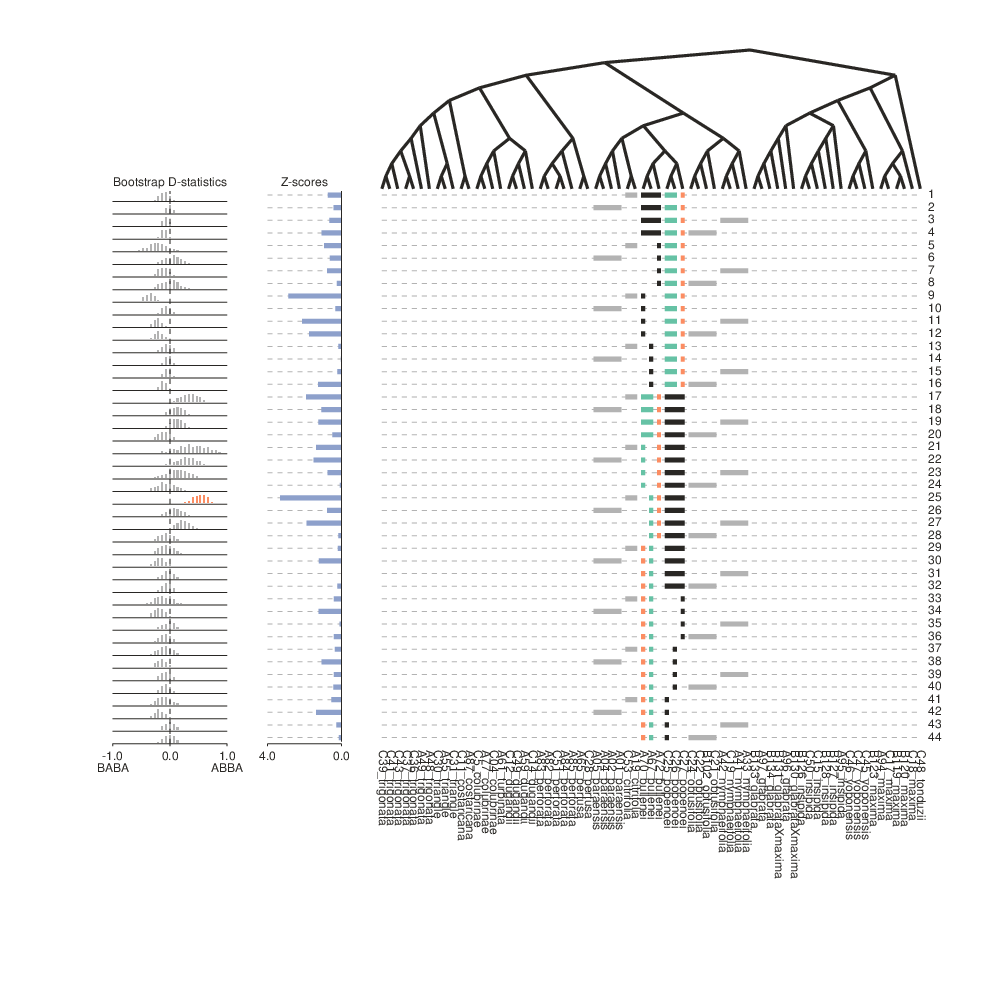

In [106]:
## load into baba
tre = baba.Tree(newick)
canvas, axes = tre.draw(
                    taxdicts=test1, 
                    bootsarr=b,
                    height=1000,
                    width=1000,
                    show_tips=True,
                    cex="12px",
                    pct_tree_x=0.5,
                    pct_tree_y=0.2,
                    #collapse_outgroup=1,
                    test_labels=True,
                    )

toyplot.pdf.render(canvas, "H1_pop-bull.pdf")
canvas

In [137]:
test2 = [
    #### perforata x bullenei
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": clades["bullenei"],
    "p1": clades["popenoei"], 
    },
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": clades["bullenei"],
    "p1": clades["paraensis"], 
    },
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": clades["bullenei"],
    "p1": clades["citrifolia"], 
    },
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": clades["bullenei"],
    "p1": clades["nymphaeifolia"], 
    },
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": clades["bullenei"],
    "p1": clades["obtusifolia"], 
    },    
    
    #### perforata x bullenei
    {
    "p4": pharma,
    "p3": ["A85_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["popenoei"], 
    },
    {
    "p4": pharma,
    "p3": ["A85_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["paraensis"], 
    },
    {
    "p4": pharma,
    "p3": ["A85_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["citrifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A85_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["nymphaeifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A85_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["obtusifolia"], 
    },      
    
    #### perforata x bullenei
    {
    "p4": pharma,
    "p3": ["A83_perforata", "A82_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["popenoei"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata", "A82_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["paraensis"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata", "A82_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["citrifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata", "A82_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["nymphaeifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata", "A82_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["obtusifolia"], 
    },    
    
    #### perforata x bullenei
    {
    "p4": pharma,
    "p3": ["A83_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["popenoei"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["paraensis"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["citrifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["nymphaeifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["obtusifolia"], 
    },  
    
    #### perforata x bullenei
    {
    "p4": pharma,
    "p3": ["C51_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["popenoei"], 
    },
    {
    "p4": pharma,
    "p3": ["C51_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["paraensis"], 
    },
    {
    "p4": pharma,
    "p3": ["C51_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["citrifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["C51_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["nymphaeifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["C51_perforata"],
    "p2": clades["bullenei"],
    "p1": clades["obtusifolia"], 
    },  
    #################################################
    
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["popenoei"], 
    },
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["paraensis"], 
    },
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["citrifolia"], 
    },
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["nymphaeifolia"], 
    },
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["obtusifolia"], 
    },    
    
    #### perforata x bullenei
    {
    "p4": pharma,
    "p3": ["A85_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["popenoei"], 
    },
    {
    "p4": pharma,
    "p3": ["A85_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["paraensis"], 
    },
    {
    "p4": pharma,
    "p3": ["A85_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["citrifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A85_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["nymphaeifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A85_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["obtusifolia"], 
    },      
    
    #### perforata x bullenei
    {
    "p4": pharma,
    "p3": ["A83_perforata", "A82_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["popenoei"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata", "A82_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["paraensis"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata", "A82_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["citrifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata", "A82_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["nymphaeifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata", "A82_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["obtusifolia"], 
    },    
    
    #### perforata x bullenei
    {
    "p4": pharma,
    "p3": ["A83_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["popenoei"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["paraensis"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["citrifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["nymphaeifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["obtusifolia"], 
    },  
    
    #### perforata x bullenei
    {
    "p4": pharma,
    "p3": ["C51_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["popenoei"], 
    },
    {
    "p4": pharma,
    "p3": ["C51_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["paraensis"], 
    },
    {
    "p4": pharma,
    "p3": ["C51_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["citrifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["C51_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["nymphaeifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["C51_perforata"],
    "p2": ["A72_bullenei"],
    "p1": clades["obtusifolia"], 
    },  
    ###########################################
    
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["popenoei"], 
    },
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["paraensis"], 
    },
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["citrifolia"], 
    },
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["nymphaeifolia"], 
    },
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["obtusifolia"], 
    },    
    
    #### perforata x bullenei
    {
    "p4": pharma,
    "p3": ["A85_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["popenoei"], 
    },
    {
    "p4": pharma,
    "p3": ["A85_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["paraensis"], 
    },
    {
    "p4": pharma,
    "p3": ["A85_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["citrifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A85_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["nymphaeifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A85_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["obtusifolia"], 
    },      
    
    #### perforata x bullenei
    {
    "p4": pharma,
    "p3": ["A83_perforata", "A82_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["popenoei"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata", "A82_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["paraensis"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata", "A82_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["citrifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata", "A82_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["nymphaeifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata", "A82_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["obtusifolia"], 
    },    
    
    #### perforata x bullenei
    {
    "p4": pharma,
    "p3": ["A83_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["popenoei"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["paraensis"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["citrifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["nymphaeifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["A83_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["obtusifolia"], 
    },  
    
    #### perforata x bullenei
    {
    "p4": pharma,
    "p3": ["C51_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["popenoei"], 
    },
    {
    "p4": pharma,
    "p3": ["C51_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["paraensis"], 
    },
    {
    "p4": pharma,
    "p3": ["C51_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["citrifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["C51_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["nymphaeifolia"], 
    },
    {
    "p4": pharma,
    "p3": ["C51_perforata"],
    "p2": ["A70_bullenei"],
    "p1": clades["obtusifolia"], 
    },  
    ###########################################
    {
    "p4": pharma,
    "p3": clades["bullenei"], 
    "p2": clades["perforata"],
    "p1": clades["pertusa"], 
    },  
    {
    "p4": pharma,
    "p3": clades["bullenei"], 
    "p2": clades["perforata"],
    "p1": clades["colubrinae"], 
    },  
    {
    "p4": pharma,
    "p3": clades["bullenei"], 
    "p2": clades["perforata"],
    "p1": clades["dugandii"], 
    },  
    {
    "p4": pharma,
    "p3": clades["bullenei"], 
    "p2": clades["perforata"],
    "p1": clades["costaricana"], 
    },  
    {
    "p4": pharma,
    "p3": clades["bullenei"], 
    "p2": clades["perforata"],
    "p1": clades["triangle"], 
    },  
    {
    "p4": pharma,
    "p3": clades["bullenei"], 
    "p2": clades["perforata"],
    "p1": clades["trigonata"], 
    },    
]

    

In [138]:
r, b = baba.batch(locfile, test2, ipyclient=ipyclient)


  [####################] 100%  calculating D-stats  | 0:01:19 |  



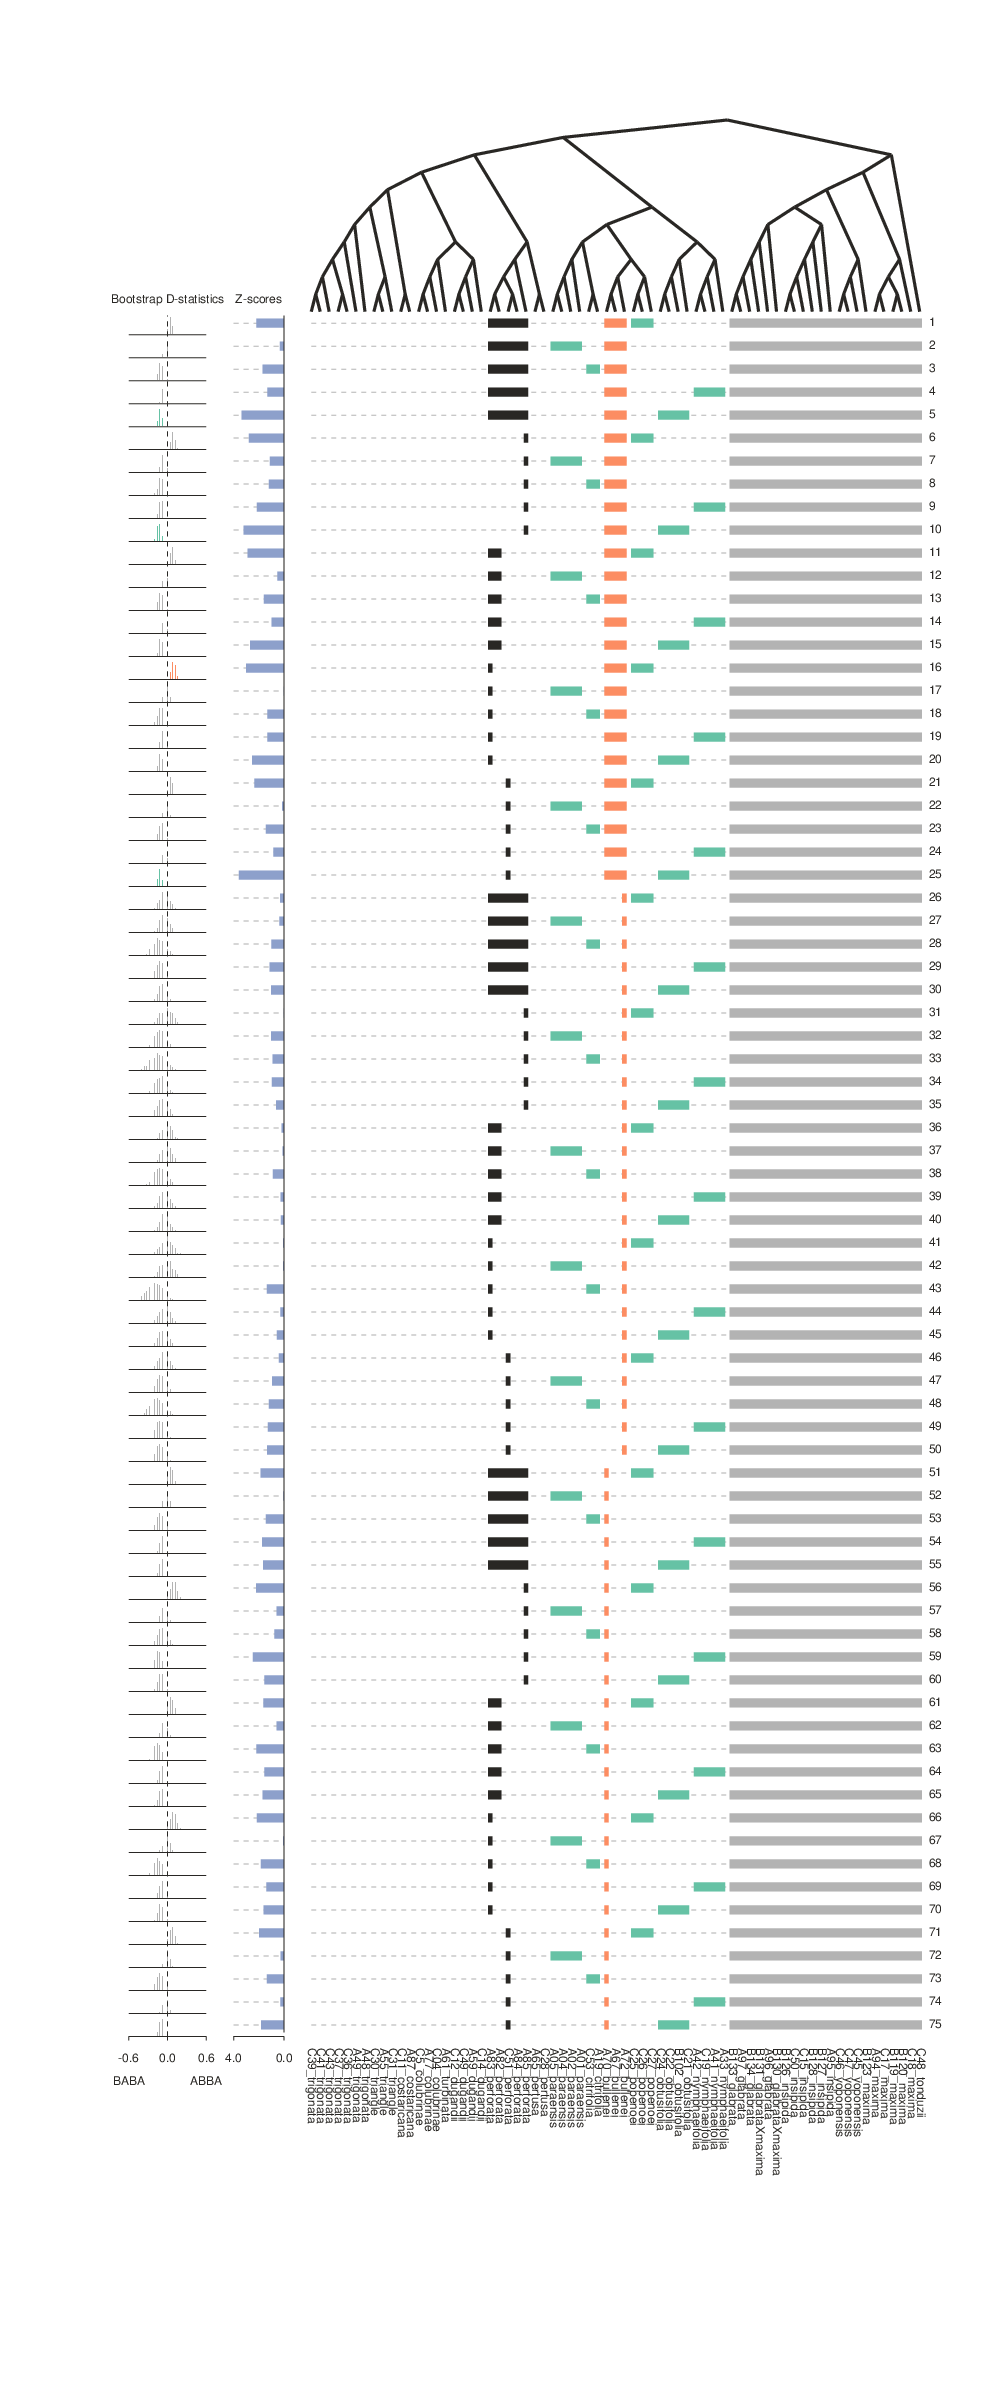

In [136]:
## load into baba
tre = baba.Tree(newick)
canvas, axes = tre.draw(
                    taxdicts=test2, 
                    bootsarr=b,
                    height=2400,
                    width=1000,
                    show_tips=True,
                    cex="12px",
                    pct_tree_x=0.3,
                    pct_tree_y=0.1,
                    #collapse_outgroup=1,
                    test_labels=True,
                    )

toyplot.pdf.render(canvas, "H2_perf-bull.pdf")
canvas

In [139]:
test3 = [
    ## popenoei x triangle
    {
    "p4": pharma,
    "p3": clades["popenoei"],
    "p2": clades["triangle"],
    "p1": clades["trigonata"],
    },
    {
    "p4": pharma,
    "p3": clades["popenoei"],
    "p2": clades["triangle"],
    "p1": clades["costaricana"],
    },
    {
    "p4": pharma,
    "p3": clades["popenoei"],
    "p2": clades["triangle"],
    "p1": clades["dugandii"],
    },
    {
    "p4": pharma,
    "p3": clades["popenoei"],
    "p2": clades["triangle"],
    "p1": clades["colubrinae"],
    },
    {
    "p4": pharma,
    "p3": clades["popenoei"],
    "p2": clades["triangle"],
    "p1": clades["perforata"],
    },
    
    
]

In [140]:
r, b = baba.batch(locfile, test3, ipyclient=ipyclient)


  [####################] 100%  calculating D-stats  | 0:00:36 |  



In [144]:
r

dstat  bootmean   bootstd         ABBA         BABA         Z
0  0.002641  0.003744  0.022751  1015.518457  1010.167861  0.164541
1  0.091572  0.092538  0.021958  1181.167344   982.991363  4.214278
2 -0.048482 -0.048439  0.021647  1130.513082  1245.717063  2.237656
3  0.158460  0.158241  0.019205  1480.358425  1075.377662  8.239374
4  0.181425  0.181416  0.019368  1615.818162  1119.552729  9.366595

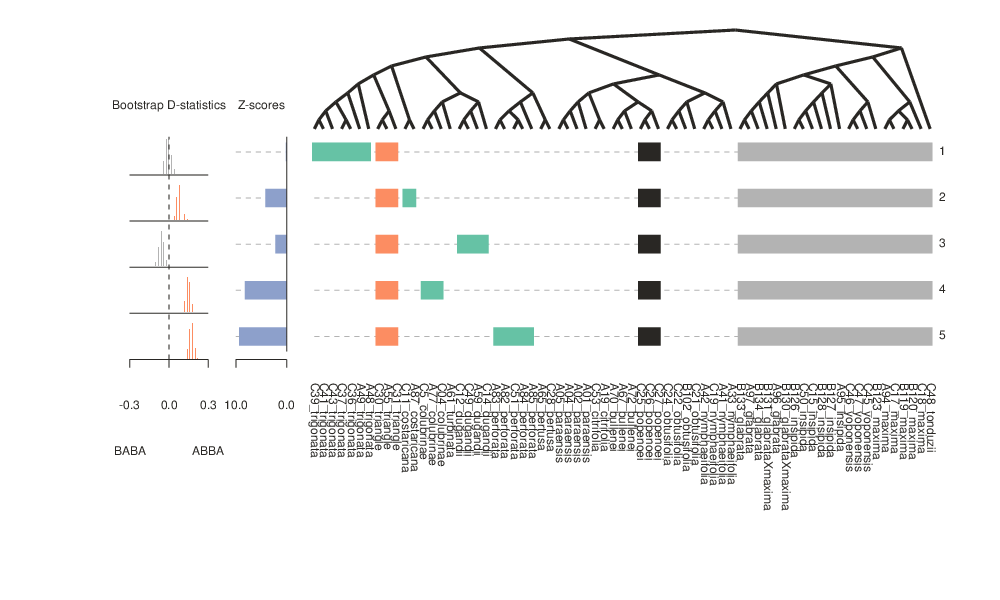

In [145]:
## load into baba
tre = baba.Tree(newick)
canvas, axes = tre.draw(
                    taxdicts=test3, 
                    bootsarr=b,
                    height=600,
                    width=1000,
                    show_tips=True,
                    cex="12px",
                    pct_tree_x=0.3,
                    pct_tree_y=0.3,
                    #collapse_outgroup=1,
                    test_labels=True,
                    )

toyplot.pdf.render(canvas, "H3_pop-tri.pdf")
canvas

### Test 4

In [147]:
test4 = [
    ## perforata x colubrinae
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": clades["colubrinae"],
    "p1": clades["trigonata"],
    },
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": clades["colubrinae"],
    "p1": clades["costaricana"],
    },
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": clades["colubrinae"],
    "p1": clades["dugandii"],
    },
    {
    "p4": pharma,
    "p3": clades["perforata"],
    "p2": clades["colubrinae"],
    "p1": clades["triangle"],
    },
    ###
    
    {
    "p4": pharma,
    "p3": clades["colubrinae"],
    "p2": clades["perforata"],
    "p1": clades["pertusa"],
    },
    
]

In [148]:
r, b = baba.batch(locfile, test4, ipyclient=ipyclient)


  [####################] 100%  calculating D-stats  | 0:00:39 |  



In [150]:
print r

      dstat  bootmean   bootstd         ABBA         BABA         Z
0  0.104676  0.104415  0.017788  1732.456297  1404.129717  5.869779
1  0.072344  0.071328  0.019457  1419.822668  1228.251508  3.665941
2  0.129217  0.129409  0.018954  1563.029168  1205.313589  6.827606
3  0.056378  0.056106  0.018343  1556.443207  1390.310623  3.058690
4  0.054910  0.055076  0.019329  1518.189999  1360.140049  2.849427


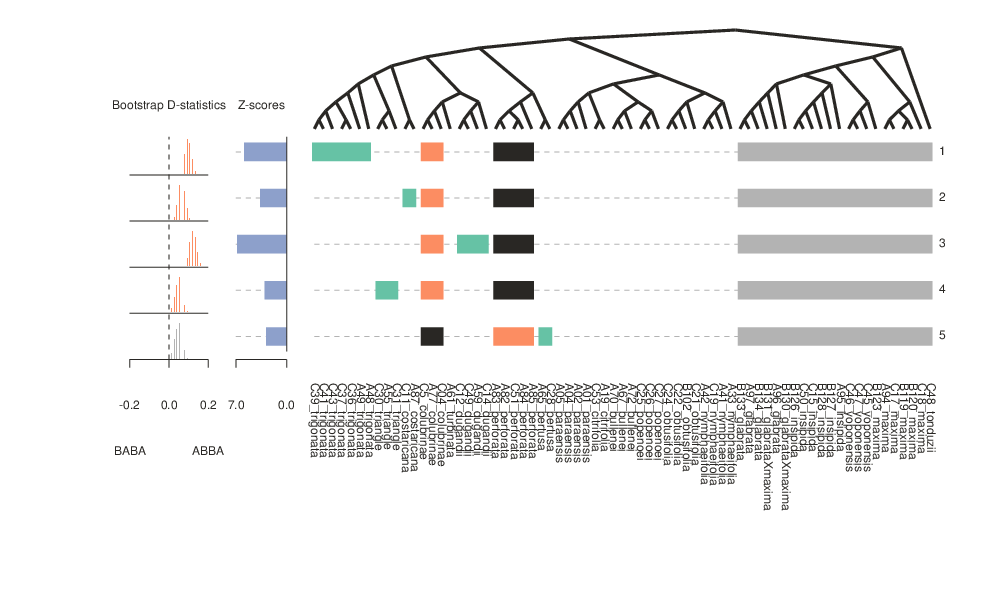

In [149]:
## load into baba
tre = baba.Tree(newick)
canvas, axes = tre.draw(
                    taxdicts=test4, 
                    bootsarr=b,
                    height=600,
                    width=1000,
                    show_tips=True,
                    cex="12px",
                    pct_tree_x=0.3,
                    pct_tree_y=0.3,
                    #collapse_outgroup=1,
                    test_labels=True,
                    )

toyplot.pdf.render(canvas, "H4_perf-colub.pdf")
canvas

### Setup up tests within *Pharmacosyceae*

In [5]:
### set up a list of tests as dictionaries, (e.g., [dict, dict, dict]). 
tests = [
    
    ## 1. tonduzii into maxim vs. all
    {
    "p4": urost1+urost2,
    "p3": clades["tonduzii"],
    "p2": clades["maxima"],
    "p1": clades["yoponensis"] + clades["insipida"] + clades["glabrata"],
    },
    
    ## 2. tonduzii into maxim vs. each lower
    {
    "p4": urost1+urost2,
    "p3": clades["tonduzii"],
    "p2": clades["maxima"],
    "p1": clades["yoponensis"],
    },
    
    ## 3. ""
    {
    "p4": urost1+urost2,
    "p3": clades["tonduzii"],
    "p2": clades["maxima"][:-1],
    "p1": clades["yoponensis"],
    },
    
    ## 4. "" 
    {
    "p4": urost1+urost2,
    "p3": clades["tonduzii"],
    "p2": clades["maxima"][-1:],
    "p1": clades["yoponensis"],
    },
    
    ## 5. 
    {
    "p4": urost1+urost2,
    "p3": clades["tonduzii"],
    "p2": clades["maxima"][-1:],
    "p1": clades["insipida"],
    },
    
    ## 6. 
    {
    "p4": urost1+urost2,
    "p3": clades["tonduzii"],
    "p2": clades["maxima"][-1:],
    "p1": clades["glabrata"],
    },
    
    ## 7.
    {
    "p4": urost1+urost2,
    "p3": clades["tonduzii"],
    "p2": clades["yoponensis"],
    "p1": clades["insipida"],
    },
    
    ## 8.
    {
    "p4": urost1+urost2,
    "p3": clades["tonduzii"],
    "p2": clades["yoponensis"],
    "p1": clades["glabrata"],
    },
    
    ## 9.
    {
    "p4": urost1+urost2,
    "p3": clades["tonduzii"],
    "p2": clades["insipida"],
    "p1": clades["glabrata"],
    },
    
    ## 10. maximas into all --------------------------
    {
    "p4": urost1+urost2,
    "p3": clades["maxima"][:-1],
    "p2": clades["yoponensis"],
    "p1": clades["glabrata"] + clades["insipida"],
    },   

    ## 11. 
    {
    "p4": urost1+urost2,
    "p3": clades["maxima"][:-1],
    "p2": clades["yoponensis"],
    "p1": clades["insipida"],
    },   
    
    ## 12. ""
    {
    "p4": urost1+urost2,
    "p3": clades["maxima"][:-1],
    "p2": clades["yoponensis"],
    "p1": clades["glabrata"],
    },   
        
    ## 13. 
    {
    "p4": urost1+urost2,
    "p3": clades["maxima"][:-1],
    "p2": clades["insipida"],
    "p1": clades["glabrata"],
    },  
    
    ## maxima B123 + yopo -------------------------
    ## 14.
    {
    "p4": urost1+urost2,
    "p3": clades["yoponensis"] + clades["maxima"][-1:],
    "p2": clades["maxima"][:1],
    "p1": clades["maxima"][1:3],
    },
    
    ## 15. ""
    {
    "p4": urost1+urost2,
    "p3": clades["yoponensis"] + clades["maxima"][-1:],
    "p2": clades["maxima"][1:3],
    "p1": clades["maxima"][3:-1],
    },

    ## 16. maxima B123 ----------------------------
    {
    "p4": urost1+urost2,
    "p3": clades["maxima"][-1:],
    "p2": clades["maxima"][:1],
    "p1": clades["maxima"][1:3],
    },
    
    ## 17. ""
    {
    "p4": urost1+urost2,
    "p3": clades["maxima"][-1:],
    "p2": clades["maxima"][1:3],
    "p1": clades["maxima"][3:-1],
    },
    
    ## 18. maxima into yopo vs. all other
    {
    "p4": urost1+urost2,
    "p3": clades["maxima"][-1:],
    "p2": clades["yoponensis"],
    "p1": clades["glabrata"] + clades["insipida"],
    },     
    
    ## 19. Yoponensis ---------------------------------
    {
    "p4": urost1+urost2,
    "p3": clades["yoponensis"],
    "p2": clades["maxima"][:1],
    "p1": clades["maxima"][1:3],
    },
    
    ## 20. ""
    {
    "p4": urost1+urost2,
    "p3": clades["yoponensis"],
    "p2": clades["maxima"][:1],
    "p1": clades["maxima"][3:-1],
    },
    
    ## 21. ""
    {
    "p4": urost1+urost2,
    "p3": clades["yoponensis"],
    "p2": clades["maxima"][1:3],
    "p1": clades["maxima"][3:-1],
    },

    ## 22. yopo into insipida v glabrata
    {
    "p4": urost1+urost2,
    "p3": clades["yoponensis"],
    "p2": clades["insipida"],
    "p1": clades["glabrata"],
    },
    
    ## 23. "" w/ only 'purest' glabrata
    {
    "p4": urost1+urost2,
    "p3": clades["yoponensis"],
    "p2": clades["insipida"],
    "p1": clades["glabrata"][-3:],
    },

    ## 24. yoponensis into maxima
    {
    "p4": urost1+urost2,
    "p3": clades["insipida"],
    "p2": clades["maxima"][:1],
    "p1": clades["maxima"][1:3],
    },
    
    ## 25.
    {
    "p4": urost1+urost2,
    "p3": clades["insipida"],
    "p2": clades["maxima"][:1],
    "p1": clades["maxima"][3:-1],
    },

    ## 26. ""
    {
    "p4": urost1+urost2,
    "p3": clades["insipida"],
    "p2": clades["maxima"][1:3],
    "p1": clades["maxima"][3:-1],
    },
    
    ## 27. insipida into yopo 
    {
    "p4": urost1+urost2,
    "p3": clades["insipida"],
    "p2": clades["yoponensis"][:1],
    "p1": clades["yoponensis"][1:],
    },
    
    ## 28. insipida into glabrata
    {
    "p4": urost1+urost2,
    "p3": clades["insipida"],
    "p2": clades["glabrata"][-2:-1],
    "p1": clades["glabrata"][-1:],
    },
    
    ## 29. ""
    {
    "p4": urost1+urost2,
    "p3": clades["insipida"],
    "p2": clades["glabrata"][-3:-2],
    "p1": clades["glabrata"][-2:],
    },
    
    ## 30. ""
    {
    "p4": urost1+urost2,
    "p3": clades["insipida"],
    "p2": clades["glabrata"][-4:-3],
    "p1": clades["glabrata"][-3:],
    },
    
    ## 31. ""
    {
    "p4": urost1+urost2,
    "p3": clades["insipida"],
    "p2": clades["glabrata"][-5:-4],
    "p1": clades["glabrata"][-4:],
    },
    
    ## 32. ""
    {
    "p4": urost1+urost2,
    "p3": clades["insipida"],
    "p2": clades["glabrata"][-6:-5],
    "p1": clades["glabrata"][-5:],
    },
    
    ## 33. ""
    {
    "p4": urost1+urost2,
    "p3": clades["insipida"],
    "p2": clades["glabrata"][-6:-5],
    "p1": clades["glabrata"][-2:],
    },

    ## 34. glabrata into anyone -------------------
    {
    "p4": urost1+urost2,
    "p3": clades["glabrata"],
    "p2": clades["insipida"][:1],
    "p1": clades["insipida"][1:],
    },  

    ## 35.
    {
    "p4": urost1+urost2,
    "p3": clades["glabrata"],
    "p2": clades["yoponensis"][:1],
    "p1": clades["yoponensis"][1:],
    },  
    
    ## 36.
    {
    "p4": urost1+urost2,
    "p3": clades["glabrata"],
    "p2": clades["maxima"][:1],
    "p1": clades["maxima"][1:-1],
    },  
    
    ## 37.
    {
    "p4": urost1+urost2,
    "p3": clades["glabrata"],
    "p2": clades["maxima"][:1],
    "p1": clades["maxima"][1:-1],
    },  
    
    ## 38.
    {
    "p4": urost1+urost2,
    "p3": clades["glabrata"][:1],
    "p2": clades["maxima"][:1],
    "p1": clades["maxima"][1:3],
    },
    
    ## 39. ""
    {
    "p4": urost1+urost2,
    "p3": clades["glabrata"][:1],
    "p2": clades["maxima"][:1],
    "p1": clades["maxima"][-3:-1]
    },
    
    ## 40. ""
    {
    "p4": urost1+urost2,
    "p3": clades["glabrata"][:1],
    "p2": clades["maxima"][1:3],
    "p1": clades["maxima"][-3:-1]
    },
 
    ## 41.
    {
    "p4": urost1+urost2,
    "p3": clades["glabrata"][1:2],
    "p2": clades["maxima"][:1],
    "p1": clades["maxima"][1:3],
    },
    
    ## 42. ""
    {
    "p4": urost1+urost2,
    "p3": clades["glabrata"][1:2],
    "p2": clades["maxima"][:1],
    "p1": clades["maxima"][-3:-1]
    },
    
    ## 43. ""
    {
    "p4": urost1+urost2,
    "p3": clades["glabrata"][1:2],
    "p2": clades["maxima"][1:3],
    "p1": clades["maxima"][-3:-1]
    },
 
    ## 44.
    {
    "p4": urost1+urost2,
    "p3": clades["glabrata"][-1:],
    "p2": clades["maxima"][:1],
    "p1": clades["maxima"][1:3],
    },
    
    ## 45. ""
    {
    "p4": urost1+urost2,
    "p3": clades["glabrata"][-1:],
    "p2": clades["maxima"][:1],
    "p1": clades["maxima"][-3:-1]
    },
    
    ## 46. ""
    {
    "p4": urost1+urost2,
    "p3": clades["glabrata"][-1:],
    "p2": clades["maxima"][1:3],
    "p1": clades["maxima"][-3:-1]
    },
]

### Run tests within *Pharmacosyceae*

In [29]:
res, boots = baba.batch(locfile, tests, 1, 1000, ipyclient)

## save boots array for later
np.savetxt("test1.npy", boots)
#boots = np.loadtxt("test.npy")

  [####################] 100%  calculating D-stats  | 0:01:40 |  


### Plot results

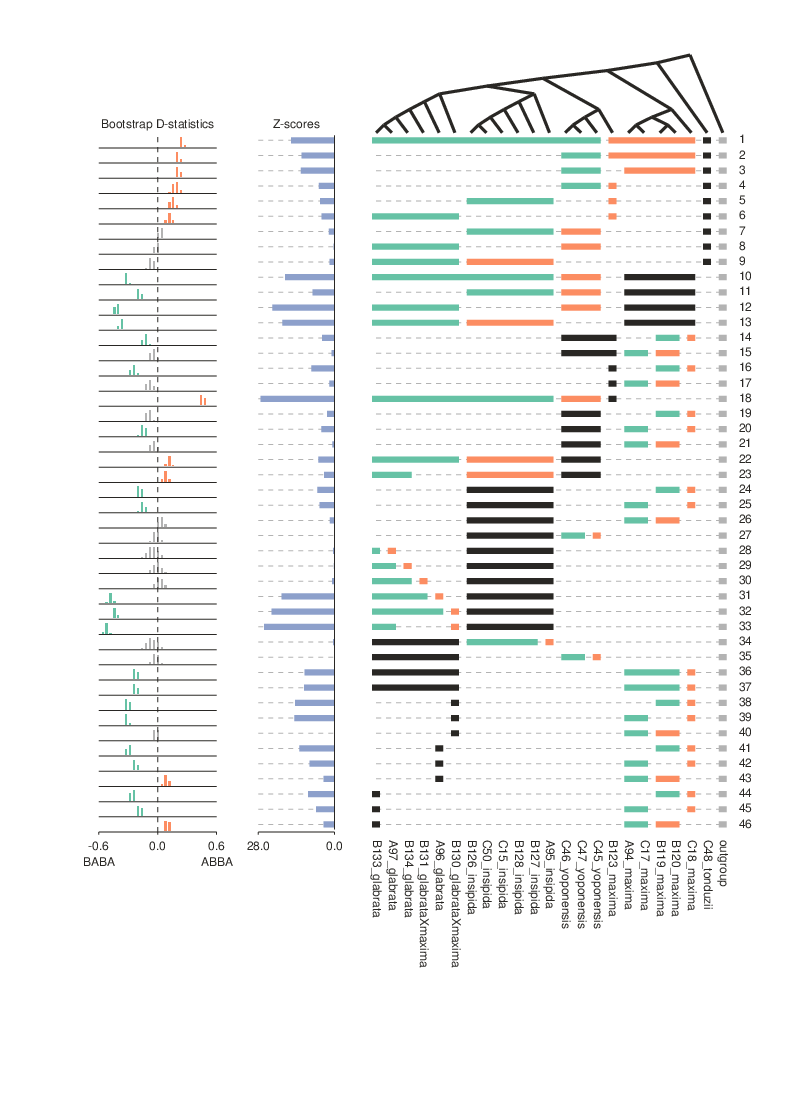

In [32]:
## load into baba
tre = baba.Tree(newick)
canvas, axes = tre.draw(
                    taxdicts=tests, 
                    bootsarr=boots,
                    height=1100,
                    width=800,
                    show_tips=True,
                    cex="12px",
                    pct_tree_x=0.8,
                    pct_tree_y=0.1,
                    collapse_outgroup=1,
                    test_labels=True,
                    )

## save to pdf
toyplot.pdf.render(canvas, "ficus-pharm-dstat.pdf")
canvas

### Interpretation: 

+ `[1-9]` *F. tonduzii* is admixed w/ *maxima* relative to (*yoponensis, insipida, glabrata) [1-3], and the same is true for *maxima* B123 `[4-6]`, suggesting that B123 shares alleles with other maximas. *F. tonduzii* does not appear admixed with *yoponensis, insipida*, or *glabrata* `[7-9]`.   

+ `[10-13]` *F. maxima* is admixed with *glabrata*, *insipida*, or their ancestor relative to *yoponensis* `[10-12]`. Seems most likely it is admixed with *glabrata* `[12-13]`. 

+ `[14-21]` *F. yoponensis* + *maxima*-B123 shows a similar pattern of admixture with the *maxima* clade as *maxima*-B123 does alone `[14-17]`. When we look at *yoponensis* alone it still appears admixed with *maxima* `[20]`, but this requires further testing (5-taxon tests). 

+ `[22-23]` *F. yoponensis* appears admixed with *insipida* relative to *glabrata*, but I suspect this is a consequence of other events. Requires further testing with 5-taxon tests. 

+ `[24-33]` *F. insipida* may be admixed with *maxima* `[24-25]`, but not recently `[26]`, and not with *insipida* `[27]`.

+ `[28-33]` *F. insipida* appears admixed with *glabrata*, but only when comparisons include B127 and A96, which are likely hybrids `[31-33]`.

+ `[34-36]` *F. glabrata* hybrids show clear admixture with *maxima*, strongest with B120 and B119. 

+ `[37]` *F. glabrata* does not appear admixed with *insipida*. 




## II. Is there gene flow between the two Americana clades?

In [6]:
### set up a list of tests as dictionaries, (e.g., [dict, dict, dict]). 
tests = [

    ## 1. uro 2 into 1
    {
    "p4": pharma,
    "p3": urost2,
    "p2": clades["obtusifolia"] + clades["nymphaeifolia"],
    "p1": clades["citrifolia"] + clades["paraensis"] + \
          clades["bullenei"] + clades["popenoei"],
    },
    
    ## 2. ""
    {
    "p4": pharma,
    "p3": urost2,
    "p2": clades["obtusifolia"] + clades["nymphaeifolia"],
    "p1": clades["citrifolia"] + clades["paraensis"],
    },
    
    ## 3. ""
    {
    "p4": pharma,
    "p3": urost2,
    "p2": clades["obtusifolia"],
    "p1": clades["citrifolia"] + clades["paraensis"],
    },
    
    ## 4. ""
    {
    "p4": pharma,
    "p3": urost2,
    "p2": clades["nymphaeifolia"],
    "p1": clades["citrifolia"] + clades["paraensis"],
    },
    
    ## 2. ""
    {
    "p4": pharma,
    "p3": urost2,
    "p2": clades["obtusifolia"] + clades["nymphaeifolia"],
    "p1": clades["bullenei"] + clades["popenoei"],
    },
    
    ## 3. ""
    {
    "p4": pharma,
    "p3": urost2,
    "p2": clades["obtusifolia"],
    "p1": clades["bullenei"] + clades["popenoei"],
    },
    
    ## 4. ""
    {
    "p4": pharma,
    "p3": urost2,
    "p2": clades["nymphaeifolia"],
    "p1": clades["bullenei"] + clades["popenoei"],
    },    
    
    {
    "p4": pharma,
    "p3": urost2,
    "p2": clades["bullenei"] + clades["popenoei"],
    "p1": clades["citrifolia"] + clades["paraensis"],
    }, 
    
    {
    "p4": pharma,
    "p3": urost2,
    "p2": clades["citrifolia"],
    "p1": clades["paraensis"],
    }, 
    
    {
    "p4": pharma,
    "p3": urost2,
    "p2": clades["popenoei"],
    "p1": clades["bullenei"],
    }, 
    
    {
    "p4": pharma,
    "p3": urost2,
    "p2": clades["nymphaeifolia"],
    "p1": clades["obtusifolia"],
    }, 
    
    ########################################
    ## 1. uro 2 into 1
    {
    "p4": pharma,
    "p3": clades["pertusa"] + clades["perforata"],
    "p2": clades["obtusifolia"] + clades["nymphaeifolia"],
    "p1": clades["citrifolia"] + clades["paraensis"] + \
          clades["bullenei"] + clades["popenoei"],
    },
    
    ## 2. ""
    {
    "p4": pharma,
    "p3": clades["pertusa"] + clades["perforata"],
    "p2": clades["obtusifolia"] + clades["nymphaeifolia"],
    "p1": clades["citrifolia"] + clades["paraensis"],
    },
    
    ## 3. ""
    {
    "p4": pharma,
    "p3": clades["pertusa"] + clades["perforata"],
    "p2": clades["obtusifolia"],
    "p1": clades["citrifolia"] + clades["paraensis"],
    },
    
    ## 4. ""
    {
    "p4": pharma,
    "p3": clades["pertusa"] + clades["perforata"],
    "p2": clades["nymphaeifolia"],
    "p1": clades["citrifolia"] + clades["paraensis"],
    },
    
    ## 2. ""
    {
    "p4": pharma,
    "p3": clades["pertusa"] + clades["perforata"],
    "p2": clades["obtusifolia"] + clades["nymphaeifolia"],
    "p1": clades["bullenei"] + clades["popenoei"],
    },
    
    ## 3. ""
    {
    "p4": pharma,
    "p3": clades["pertusa"] + clades["perforata"],
    "p2": clades["obtusifolia"],
    "p1": clades["bullenei"] + clades["popenoei"],
    },
    
    ## 4. ""
    {
    "p4": pharma,
    "p3": clades["pertusa"] + clades["perforata"],
    "p2": clades["nymphaeifolia"],
    "p1": clades["bullenei"] + clades["popenoei"],
    },    
    
    {
    "p4": pharma,
    "p3": clades["pertusa"] + clades["perforata"],
    "p2": clades["bullenei"] + clades["popenoei"],
    "p1": clades["citrifolia"] + clades["paraensis"],
    }, 
    
    {
    "p4": pharma,
    "p3": clades["pertusa"] + clades["perforata"],
    "p2": clades["citrifolia"],
    "p1": clades["paraensis"],
    }, 
    
    {
    "p4": pharma,
    "p3": clades["pertusa"] + clades["perforata"],
    "p2": clades["popenoei"],
    "p1": clades["bullenei"],
    }, 
    
    {
    "p4": pharma,
    "p3": clades["pertusa"] + clades["perforata"],
    "p2": clades["nymphaeifolia"],
    "p1": clades["obtusifolia"],
    }, 
    
    ###############################################
    {
    "p4": pharma,
    "p3": clades["turbinata"] + clades["colubrinae"] + clades["dugandii"],
    "p2": clades["obtusifolia"] + clades["nymphaeifolia"],
    "p1": clades["citrifolia"] + clades["paraensis"] + \
          clades["bullenei"] + clades["popenoei"],
    },
    
    ## 2. ""
    {
    "p4": pharma,
    "p3": clades["turbinata"] + clades["colubrinae"] + clades["dugandii"],
    "p2": clades["obtusifolia"] + clades["nymphaeifolia"],
    "p1": clades["citrifolia"] + clades["paraensis"],
    },
    
    ## 3. ""
    {
    "p4": pharma,
    "p3": clades["turbinata"] + clades["colubrinae"] + clades["dugandii"],
    "p2": clades["obtusifolia"],
    "p1": clades["citrifolia"] + clades["paraensis"],
    },
    
    ## 4. ""
    {
    "p4": pharma,
    "p3": clades["turbinata"] + clades["colubrinae"] + clades["dugandii"],
    "p2": clades["nymphaeifolia"],
    "p1": clades["citrifolia"] + clades["paraensis"],
    },
    
    ## 2. ""
    {
    "p4": pharma,
    "p3": clades["turbinata"] + clades["colubrinae"] + clades["dugandii"],
    "p2": clades["obtusifolia"] + clades["nymphaeifolia"],
    "p1": clades["bullenei"] + clades["popenoei"],
    },
    
    ## 3. ""
    {
    "p4": pharma,
    "p3": clades["turbinata"] + clades["colubrinae"] + clades["dugandii"],
    "p2": clades["obtusifolia"],
    "p1": clades["bullenei"] + clades["popenoei"],
    },
    
    ## 4. ""
    {
    "p4": pharma,
    "p3": clades["turbinata"] + clades["colubrinae"] + clades["dugandii"],
    "p2": clades["nymphaeifolia"],
    "p1": clades["bullenei"] + clades["popenoei"],
    },    
    
    {
    "p4": pharma,
    "p3": clades["turbinata"] + clades["colubrinae"] + clades["dugandii"],
    "p2": clades["bullenei"] + clades["popenoei"],
    "p1": clades["citrifolia"] + clades["paraensis"],
    }, 
    
    {
    "p4": pharma,
    "p3": clades["turbinata"] + clades["colubrinae"] + clades["dugandii"],
    "p2": clades["citrifolia"],
    "p1": clades["paraensis"],
    }, 
    
    {
    "p4": pharma,
    "p3": clades["turbinata"] + clades["colubrinae"] + clades["dugandii"],
    "p2": clades["popenoei"],
    "p1": clades["bullenei"],
    }, 
    
    {
    "p4": pharma,
    "p3": clades["turbinata"] + clades["colubrinae"] + clades["dugandii"],
    "p2": clades["nymphaeifolia"],
    "p1": clades["obtusifolia"],
    }, 
    ####################################################
    {
    "p4": pharma,
    "p3": clades["costaricana"] + clades["triangle"] + clades["trigonata"],
    "p2": clades["obtusifolia"] + clades["nymphaeifolia"],
    "p1": clades["citrifolia"] + clades["paraensis"] + \
          clades["bullenei"] + clades["popenoei"],
    },
    
    ## 2. ""
    {
    "p4": pharma,
    "p3": clades["costaricana"] + clades["triangle"] + clades["trigonata"],
    "p2": clades["obtusifolia"] + clades["nymphaeifolia"],
    "p1": clades["citrifolia"] + clades["paraensis"],
    },
    
    ## 3. ""
    {
    "p4": pharma,
    "p3": clades["costaricana"] + clades["triangle"] + clades["trigonata"],
    "p2": clades["obtusifolia"],
    "p1": clades["citrifolia"] + clades["paraensis"],
    },
    
    ## 4. ""
    {
    "p4": pharma,
    "p3": clades["costaricana"] + clades["triangle"] + clades["trigonata"],
    "p2": clades["nymphaeifolia"],
    "p1": clades["citrifolia"] + clades["paraensis"],
    },
    
    ## 2. ""
    {
    "p4": pharma,
    "p3": clades["costaricana"] + clades["triangle"] + clades["trigonata"],
    "p2": clades["obtusifolia"] + clades["nymphaeifolia"],
    "p1": clades["bullenei"] + clades["popenoei"],
    },
    
    ## 3. ""
    {
    "p4": pharma,
    "p3": clades["costaricana"] + clades["triangle"] + clades["trigonata"],
    "p2": clades["obtusifolia"],
    "p1": clades["bullenei"] + clades["popenoei"],
    },
    
    ## 4. ""
    {
    "p4": pharma,
    "p3": clades["costaricana"] + clades["triangle"] + clades["trigonata"],
    "p2": clades["nymphaeifolia"],
    "p1": clades["bullenei"] + clades["popenoei"],
    },    
    
    {
    "p4": pharma,
    "p3": clades["costaricana"] + clades["triangle"] + clades["trigonata"],
    "p2": clades["bullenei"] + clades["popenoei"],
    "p1": clades["citrifolia"] + clades["paraensis"],
    }, 
    
    {
    "p4": pharma,
    "p3": clades["costaricana"] + clades["triangle"] + clades["trigonata"],
    "p2": clades["citrifolia"],
    "p1": clades["paraensis"],
    }, 
    
    {
    "p4": pharma,
    "p3": clades["costaricana"] + clades["triangle"] + clades["trigonata"],
    "p2": clades["popenoei"],
    "p1": clades["bullenei"],
    }, 
    
    {
    "p4": pharma,
    "p3": clades["costaricana"] + clades["triangle"] + clades["trigonata"],
    "p2": clades["nymphaeifolia"],
    "p1": clades["obtusifolia"],
    }, 
]


In [34]:
res, boots = baba.batch(locfile, tests, 1, 1000, ipyclient)
#print res
#boots = np.zeros((len(tests), 1000))

  [####################] 100%  calculating D-stats  | 0:01:46 |  


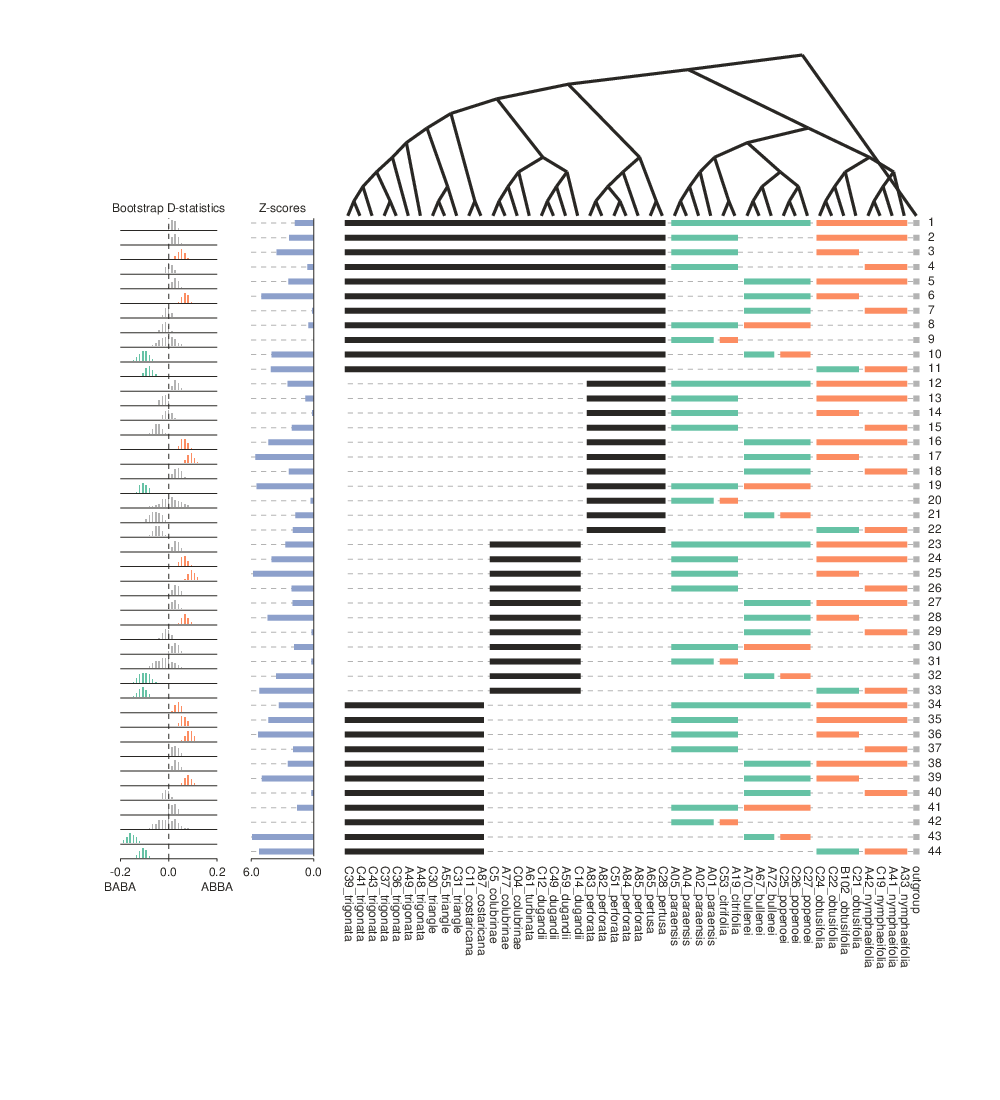

In [37]:
## load into baba
tre = baba.Tree(newick)
canvas, axes = tre.draw(
                    taxdicts=tests, 
                    bootsarr=boots,
                    height=1100,
                    width=1000,
                    show_tips=True,
                    cex="12px",
                    pct_tree_x=0.4,
                    pct_tree_y=0.2,
                    test_labels=True,
                    collapse_outgroup=1
                    )

## save figure
toyplot.pdf.render(canvas, "cladeI_dstat.pdf")
canvas

### Interpretation: 
There is some evidence of introgression between the two big clades, particularly in obtusifolia and paraensis. However, this may be due to introgression within either clade. 

In [84]:
scaffold = [
    {
    "p4": pharma,
    "p3": clades["obtusifolia"],
    "p2": clades["pertusa"] + clades["perforata"],
    "p1": clades["dugandii"] + clades["turbinata"] + \
          clades["colubrinae"] + clades["costaricana"] + \
          clades["triangle"] + clades["trigonata"],
    },
    
    {
    "p4": pharma,
    "p3": clades["obtusifolia"],
    "p2": clades["pertusa"] + clades["perforata"],
    "p1": clades["dugandii"] + clades["turbinata"] + \
          clades["colubrinae"] 
    },
    
    {
    "p4": pharma,
    "p3": clades["obtusifolia"],
    "p2": clades["pertusa"] + clades["perforata"],
    "p1": clades["dugandii"] 
    },
    
    {
    "p4": pharma,
    "p3": clades["obtusifolia"],
    "p2": clades["pertusa"] + clades["perforata"],
    "p1": clades["turbinata"] + clades["colubrinae"]
    },
    
    ## ...
    {
    "p4": pharma,
    "p3": clades["obtusifolia"],
    "p2": clades["dugandii"] + clades["turbinata"] + clades["colubrinae"],
    "p1": clades["costaricana"] + clades["triangle"] + clades["trigonata"],
    },
    
    {
    "p4": pharma,
    "p3": clades["obtusifolia"],
    "p2": clades["dugandii"] + clades["turbinata"] + clades["colubrinae"],
    "p1": clades["costaricana"] 
    },
    
    {
    "p4": pharma,
    "p3": clades["obtusifolia"],
    "p2": clades["dugandii"] + clades["turbinata"] + clades["colubrinae"],
    "p1": clades["triangle"] + clades["trigonata"],
    },
    
    {
    "p4": pharma,
    "p3": clades["obtusifolia"],
    "p2": clades["dugandii"] + clades["turbinata"] + clades["colubrinae"],
    "p1": clades["triangle"]
    },
    
    {
    "p4": pharma,
    "p3": clades["obtusifolia"],
    "p2": clades["dugandii"] + clades["turbinata"] + clades["colubrinae"],
    "p1": clades["trigonata"],
    },
    
    ##############
    {
    "p4": pharma,
    "p3": clades["obtusifolia"],
    "p2": clades["costaricana"],
    "p1": clades["triangle"] + clades["trigonata"],
    },

    {
    "p4": pharma,
    "p3": clades["obtusifolia"],
    "p2": clades["costaricana"],
    "p1": clades["triangle"],
    },
    
    {
    "p4": pharma,
    "p3": clades["obtusifolia"],
    "p2": clades["costaricana"],
    "p1": clades["trigonata"],
    },
    
    ###############
    {
    "p4": pharma,
    "p3": clades["obtusifolia"],
    "p2": clades["triangle"],
    "p1": clades["trigonata"],
    },
]

In [96]:
import copy
tests = []

p3s = [
    clades["nymphaeifolia"],
    clades["obtusifolia"],
    clades["popenoei"],
    clades["bullenei"],
    clades["citrifolia"],
    clades["paraensis"],
]

for p3 in p3s:
    for tdict in scaffold:
        tdict['p3'] = p3
        tests.append(copy.copy(tdict))

In [97]:
res, boots = baba.batch(locfile, tests, 1, 1000, ipyclient)

  [####################] 100%  calculating D-stats  | 0:02:33 |  


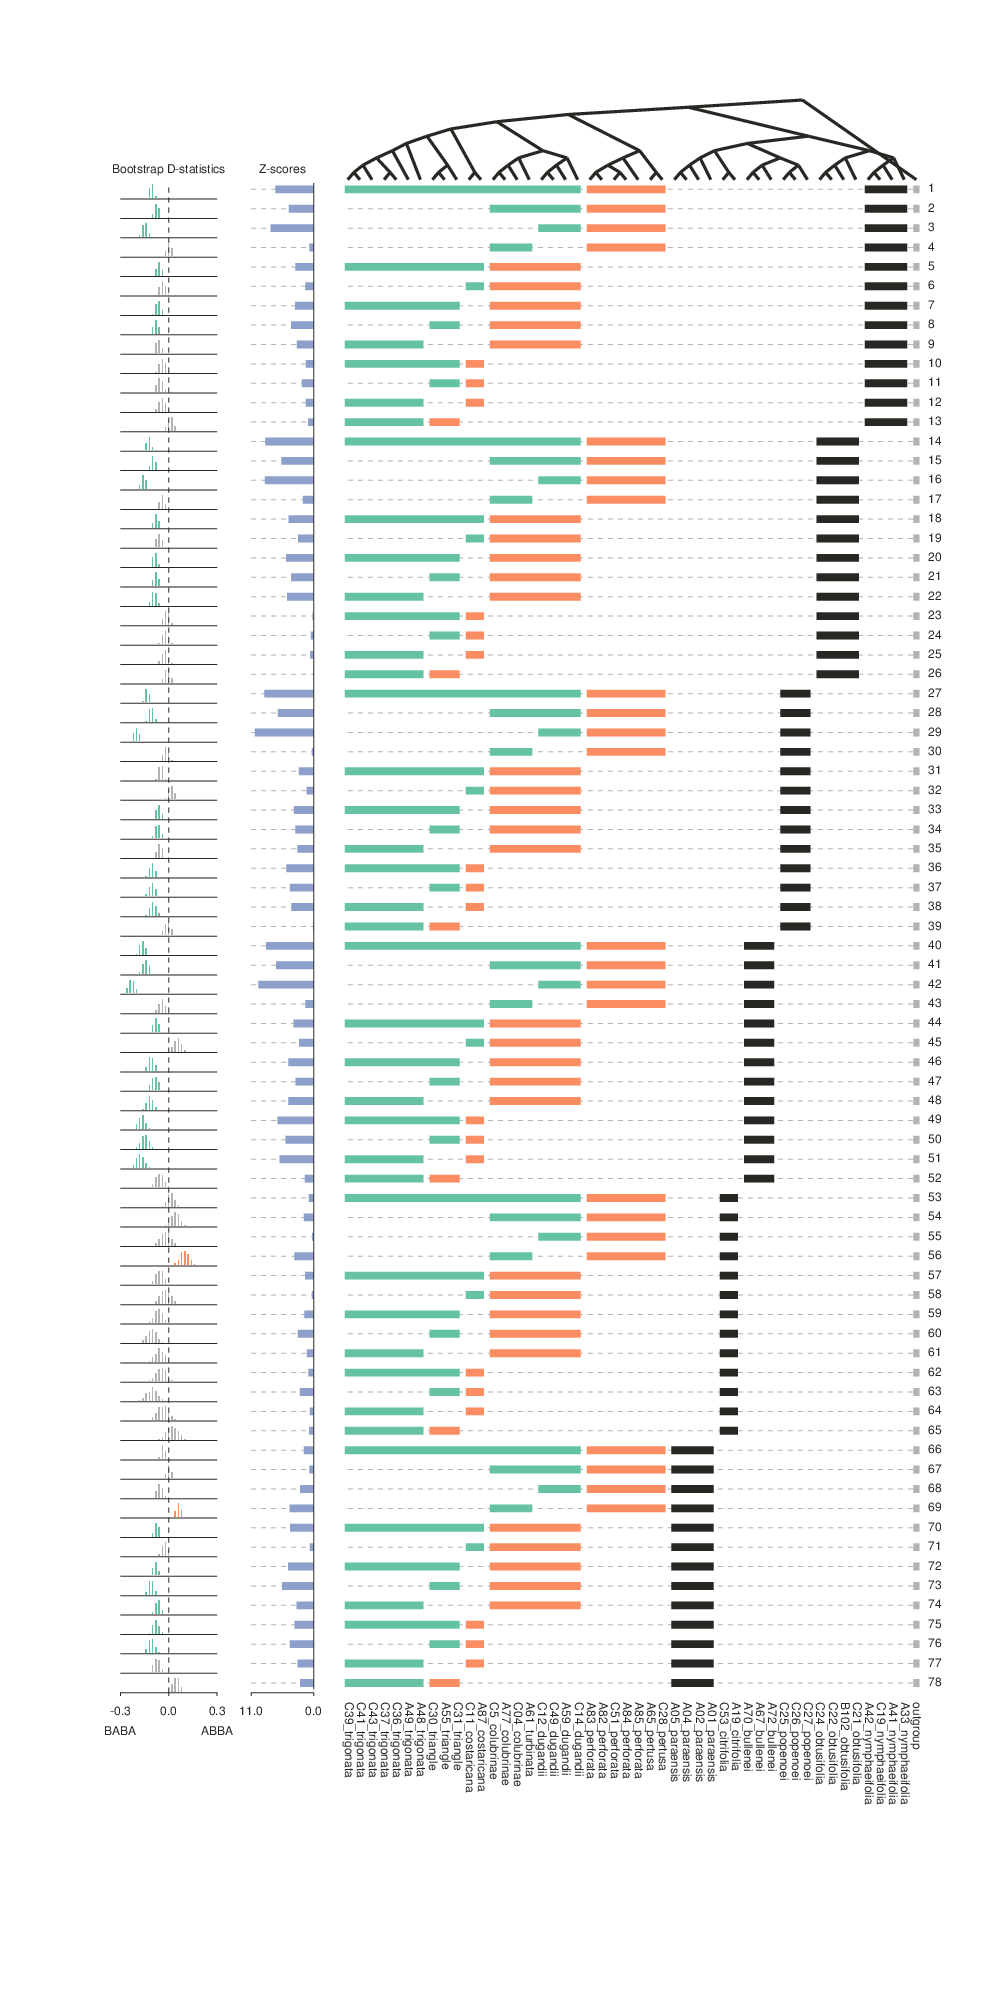

In [100]:
## load into baba
tre = baba.Tree(newick)
canvas, axes = tre.draw(
                    taxdicts=tests, 
                    bootsarr=boots,
                    height=2000,
                    width=1000,
                    show_tips=True,
                    cex="12px",
                    pct_tree_x=0.4,
                    pct_tree_y=0.05,
                    test_labels=True,
                    collapse_outgroup=1
                    )

toyplot.pdf.render(canvas, "cladeII_dstat.pdf")
canvas

### Set up tests within *Urostigma I*

In [117]:
### set up a list of tests as dictionaries, (e.g., [dict, dict, dict]). 
tests = [
    
    ## P3 = obtusifolia + nymphaeifolia
    {
    "p4": pharma,
    "p3": clades["obtusifolia"] + clades["nymphaeifolia"],
    "p2": clades["citrifolia"] + clades["paraensis"],
    "p1": clades["bullenei"] + clades["popenoei"],
    },

    {
    "p4": pharma,
    "p3": clades["obtusifolia"] + clades["nymphaeifolia"],
    "p2": clades["citrifolia"],
    "p1": clades["paraensis"],
    },
    
    {
    "p4": pharma,
    "p3": clades["obtusifolia"] + clades["nymphaeifolia"],
    "p2": clades["bullenei"],
    "p1": clades["popenoei"],
    },
    
    ## P3 = obtusifolia
    {
    "p4": pharma,
    "p3": clades["obtusifolia"],
    "p2": clades["citrifolia"] + clades["paraensis"],
    "p1": clades["bullenei"] + clades["popenoei"],
    },
    
    {
    "p4": pharma,
    "p3": clades["obtusifolia"],
    "p2": clades["citrifolia"],
    "p1": clades["paraensis"],
    },
    
    {
    "p4": pharma,
    "p3": clades["obtusifolia"],
    "p2": clades["bullenei"],
    "p1": clades["popenoei"],
    },

    ## P3 = nymphaeifolia
    {
    "p4": pharma,
    "p3": clades["nymphaeifolia"],
    "p2": clades["citrifolia"] + clades["paraensis"],
    "p1": clades["bullenei"] + clades["popenoei"],
    },
    
    {
    "p4": pharma,
    "p3": clades["nymphaeifolia"],
    "p2": clades["citrifolia"],
    "p1": clades["paraensis"],
    },
    
    {
    "p4": pharma,
    "p3": clades["nymphaeifolia"],
    "p2": clades["bullenei"],
    "p1": clades["popenoei"],
    },
]

In [118]:
res, boots = baba.batch(locfile, tests, 1, 1000, ipyclient)

#np.savetxt("test2.npy", boots)
#boots = np.loadtxt("test2.npy")

  [####################] 100%  calculating D-stats  | 0:00:37 |  


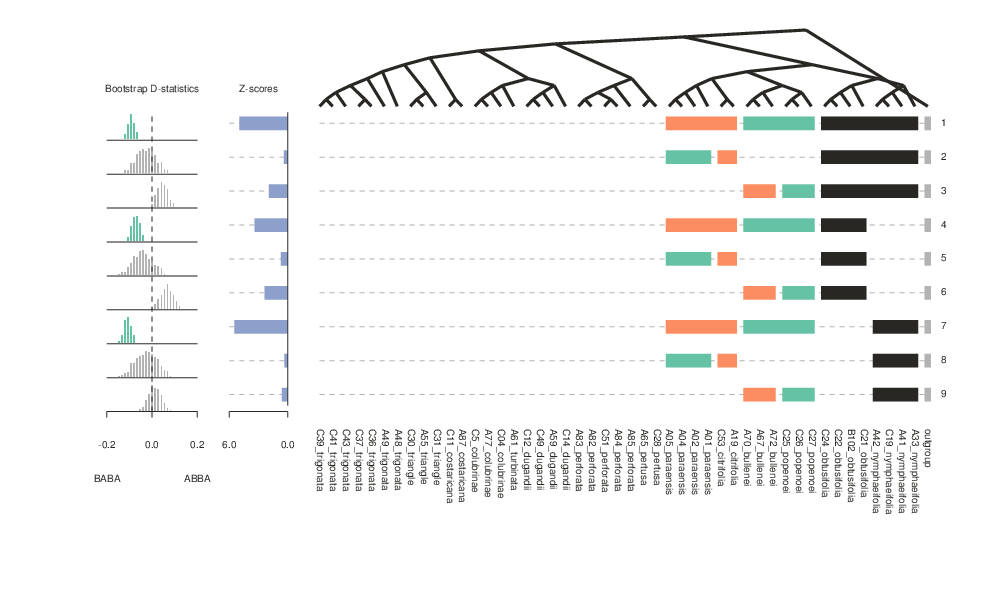

In [119]:
## load into baba
tre = baba.Tree(newick)
canvas, axes = tre.draw(
                    taxdicts=tests, 
                    bootsarr=boots,
                    height=600,
                    width=1000,
                    use_edge_lengths=False,
                    vlshow=False, 
                    vsize=0,
                    show_tips=True,
                    cex="10px",
                    pct_tree_x=0.35,
                    pct_tree_y=0.2,
                    test_labels=True,
                    collapse_outgroup=1
                    )

toyplot.pdf.render(canvas, "cladeI_within.pdf")
canvas

### Interpretation: 
Both nymph and obtus appear more closely related to bull and popo than to cit and para, but this could be caused by other stufff. 

In [121]:
taxd = {
    "p5": pharma,
    "p4": clades["nymphaeifolia"],
    "p3": clades["obtusifolia"],
    "p2": clades["popenoei"] + clades["bullenei"],
    "p1": clades["citrifolia"] + clades["paraensis"],
}

r, b = baba.baba(locfile, taxd)
print r

           dstat  bootmean   bootstd        abxxa        baxxa         Z
p3     -0.002673 -0.005165  0.035333   398.450032   400.585925  0.075653
p4      0.061482  0.060868  0.034407   413.328625   365.448098  1.786881
shared  0.081524  0.081090  0.017769  1425.314761  1210.438384  4.588082


In [122]:
taxd = {
    "p5": pharma,
    "p4": clades["nymphaeifolia"],
    "p3": clades["obtusifolia"],
    "p2": clades["trigonata"],
    "p1": clades["triangle"],
}

r, b = baba.baba(locfile, taxd)
print r

           dstat  bootmean   bootstd       abxxa       baxxa         Z
p3      0.062548  0.062441  0.034743  313.102063  276.239682  1.800318
p4      0.025815  0.024843  0.039323  248.455621  235.950580  0.656489
shared -0.000469 -0.000912  0.020017  935.601534  936.479764  0.023436


In [124]:
taxd = {
    "p5": pharma,
    "p4": clades["nymphaeifolia"] + clades["obtusifolia"],
    "p3": clades["popenoei"] + clades["bullenei"] + \
          clades["citrifolia"] + clades["paraensis"],
    "p2": clades["trigonata"],
    "p1": clades["triangle"],
}

r, b = baba.baba(locfile, taxd)
print r

           dstat  bootmean   bootstd        abxxa        baxxa         Z
p3      0.035033  0.033779  0.037836   336.765732   313.968801  0.925896
p4      0.030109  0.032005  0.036320   252.068751   237.333429  0.828986
shared -0.012247 -0.011965  0.018472  1081.879968  1108.707134  0.662975


### This is interesting... 
There is clearly alleles derived in cladeI that are present in triangle+trigonata and not in pertusa+perforata. But the alleles are not unique to one of the P3 clades more than other. 

## Five-taxon tests

In [126]:
taxd = {
    "p5": pharma,
    "p4": clades["nymphaeifolia"] + clades["obtusifolia"],
    "p3": clades["popenoei"] + clades["bullenei"] + \
          clades["citrifolia"] + clades["paraensis"],
    "p2": clades["triangle"] + clades["trigonata"], 
    "p1": clades["pertusa"] + clades["perforata"],
}

r, b = baba.baba(locfile, taxd)
print r

           dstat  bootmean   bootstd        abxxa        baxxa         Z
p3      0.033814  0.033515  0.026081   485.707159   453.933874  1.296503
p4      0.057573  0.058052  0.030143   415.849701   370.573005  1.909997
shared  0.120929  0.121156  0.013026  1904.052959  1493.224146  9.283523


In [127]:
taxd = {
    "p5": pharma,
    "p4": clades["nymphaeifolia"] + clades["obtusifolia"],
    "p3": clades["popenoei"] + clades["bullenei"] + \
          clades["citrifolia"] + clades["paraensis"],
    "p2": clades["triangle"] + clades["trigonata"], 
    "p1": clades["dugandii"],
}

r, b = baba.baba(locfile, taxd)
print r

           dstat  bootmean   bootstd        abxxa        baxxa         Z
p3     -0.057134 -0.058079  0.029430   355.848597   398.974959  1.941385
p4      0.003781  0.003611  0.035411   310.490398   308.151587  0.106763
shared  0.000265  0.000381  0.015869  1292.568397  1291.883337  0.016704


In [128]:
taxd = {
    "p5": pharma,
    "p4": clades["nymphaeifolia"] + clades["obtusifolia"],
    "p3": clades["popenoei"] + clades["bullenei"] + \
          clades["citrifolia"] + clades["paraensis"],
    "p2": clades["triangle"] + clades["trigonata"], 
    "p1": clades["costaricana"],
}

r, b = baba.baba(locfile, taxd)
print r

           dstat  bootmean   bootstd        abxxa        baxxa         Z
p3      0.141154  0.140850  0.033567   370.356806   278.734911  4.205148
p4     -0.051881 -0.050721  0.033548   273.526889   303.461634  1.546486
shared  0.054310  0.054441  0.016184  1279.914185  1148.051249  3.355855


In [129]:
taxd = {
    "p5": pharma,
    "p4": clades["nymphaeifolia"] + clades["obtusifolia"],
    "p3": clades["popenoei"] + clades["bullenei"] + \
          clades["citrifolia"] + clades["paraensis"],
    "p2": clades["triangle"] + clades["trigonata"], 
    "p1": clades["colubrinae"],
}

r, b = baba.baba(locfile, taxd)
print r

           dstat  bootmean   bootstd        abxxa        baxxa          Z
p3      0.102192  0.102269  0.026874   455.601325   371.117384   3.802657
p4      0.053140  0.053226  0.029638   350.833652   315.428357   1.792947
shared  0.144485  0.143998  0.014002  1719.941672  1285.673833  10.318870


In [131]:
taxd = {
    "p5": pharma,
    "p4": clades["paraensis"] + clades["citrifolia"],
    "p3": clades["popenoei"] + clades["bullenei"],
    "p2": clades["triangle"] + clades["trigonata"], 
    "p1": clades["colubrinae"],
}

r, b = baba.baba(locfile, taxd)
print r

           dstat  bootmean   bootstd        abxxa        baxxa         Z
p3      0.189258  0.188124  0.026778   551.069861   375.675690  7.067596
p4      0.064098  0.063212  0.030663   443.013460   389.641973  2.090420
shared  0.156644  0.156557  0.015940  1518.715535  1107.356320  9.827011


In [137]:
taxd = {
    "p5": pharma,
    "p4": clades["paraensis"] + clades["citrifolia"],
    "p3": clades["popenoei"] + clades["bullenei"],
    "p2": clades["triangle"] + clades["trigonata"], 
    "p1": clades["colubrinae"] + clades["turbinata"] + clades["dugandii"]
}

r, b = baba.baba(locfile, taxd)
print r

           dstat  bootmean   bootstd        abxxa        baxxa         Z
p3      0.077703  0.076939  0.024612   519.374463   444.480214  3.157160
p4      0.059105  0.058320  0.027108   427.583515   379.859703  2.180312
shared  0.071053  0.070514  0.014404  1389.949555  1205.532465  4.933022


### popenoei & bullenei into triangle & trigonata

In [133]:
taxd = {
    "p5": pharma,
    "p4": clades["paraensis"] + clades["citrifolia"],
    "p3": clades["popenoei"] + clades["bullenei"],
    "p2": clades["triangle"] + clades["trigonata"], 
    "p1": clades["costaricana"],
}

r, b = baba.baba(locfile, taxd)
print r

           dstat  bootmean   bootstd        abxxa       baxxa         Z
p3      0.147281  0.146471  0.031326   470.445278  349.659297  4.701623
p4      0.011171  0.010835  0.034336   345.645705  338.008590  0.325348
shared  0.103484  0.103814  0.017758  1193.904885  969.978497  5.827452


In [134]:
## reverse of test above
taxd = {
    "p5": pharma,
    "p4": clades["triangle"] + clades["trigonata"], 
    "p3": clades["costaricana"],
    "p2": clades["paraensis"] + clades["citrifolia"],
    "p1": clades["popenoei"] + clades["bullenei"],
}

r, b = baba.baba(locfile, taxd)
print r

           dstat  bootmean   bootstd        abxxa        baxxa         Z
p3      0.086178  0.082890  0.047690   232.796593   195.856300  1.807053
p4     -0.063502 -0.063675  0.028613   433.349612   492.118955  2.219363
shared -0.024136 -0.024033  0.018690  1244.741581  1306.314702  1.291377


In [135]:
## evidence of unidirectional 
taxd = {
    "p5": pharma,
    "p4": clades["triangle"] + clades["trigonata"], 
    "p3": clades["colubrinae"],
    "p2": clades["paraensis"] + clades["citrifolia"],
    "p1": clades["popenoei"] + clades["bullenei"],
}

r, b = baba.baba(locfile, taxd)
print r

           dstat  bootmean   bootstd        abxxa        baxxa         Z
p3      0.113628  0.113601  0.037851   269.097593   214.183319  3.002012
p4     -0.013747 -0.014222  0.031654   409.555965   420.973579  0.434304
shared -0.012058 -0.010935  0.018067  1381.287861  1415.006059  0.667420


In [136]:
## evidence of unidirectional 
taxd = {
    "p5": pharma,
    "p4": clades["triangle"] + clades["trigonata"], 
    "p3": clades["colubrinae"] + clades["turbinata"] + clades["dugandii"],
    "p2": clades["paraensis"] + clades["citrifolia"],
    "p1": clades["popenoei"] + clades["bullenei"],
}

r, b = baba.baba(locfile, taxd)
print r

           dstat  bootmean   bootstd        abxxa        baxxa         Z
p3      0.012205  0.011503  0.034295   262.389104   256.061612  0.355868
p4      0.016217  0.014947  0.036108   288.568999   279.358878  0.449130
shared -0.032380 -0.032844  0.017065  1420.838457  1515.930799  1.897470


In [132]:
taxd = {
    "p5": pharma,
    "p4": clades["paraensis"] + clades["citrifolia"],
    "p3": clades["popenoei"] + clades["bullenei"],
    "p2": clades["triangle"],
    "p1": clades["trigonata"], 
}

r, b = baba.baba(locfile, taxd)
print r

           dstat  bootmean   bootstd       abxxa       baxxa         Z
p3     -0.099512 -0.099624  0.034017  324.260665  395.928244  2.925362
p4      0.113060  0.113707  0.035426  364.988775  290.840871  3.191413
shared  0.003072  0.002653  0.020188  974.925650  968.954006  0.152172
